# Previsão de Deputados Eleitos

### Sobre a tarefa

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados serão eleitos nas eleições de 2014. De forma específica:

1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (2 pt.)
2. Treine: um modelo de regressão logística, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
3. Reporte acurácia, precision, recall e f-measure no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
4. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo? Crie pelo menos um novo atributo que não está nos dados originais e estude o impacto desse atributo (2 pts.)
5. Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
    1. Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
    2. Experimente balancear as classes,  caso estejam desbalanceadas.
    3. Crie pelo menos um novo atributo.
    
Os dados estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data (Links para um site externo)Links para um site externo

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.

**Obs**: Vocês estarão competindo com os alunos de graduação da disciplina Ciência de Dados Preditiva, que estarão trabalhando nesta mesma atividade.

### Sobre os dados

Os dados utilizados correspondem aos das eleições de Deputado Federal nos anos de 2006, 2010 e 2014. Estão dividos nas seguintes colunas:

    ano: Ano da eleição;
    sequencial_candidato: O identificador do candidato. Corresponde à coluna Id do arquivo de submissão;
    nome: Nome do candidato;
    uf: Sigla do estado do candidato;
    partido: Partido do candidato;
    quantidade_doacoes: Número de doações que um candidato recebeu;
    quantidade_doadores: Numero de doadores que um candidato teve;
    total_receita: Total de receita de um candidato;
    media_receita: Média da receita de um candidato;
    recursos_de_outros_candidatos.comites: Total de receita proveniente de outros candidatos e comitês;
    recursos_de_pessoas_fisicas: Total de receita proveniente de pessoas físicas;
    recursos_de_pessoas_juridicas: Total de receita proveniente de pessoas juridicas;
    recursos_proprios:Total de receita proveniente dos próprios candidatos;
    recursos_de_partido_politico: Total de receita proveniente do partido do candidato;
    quantidade_despesas: Número de despesas que um candidato teve;
    quantidade_fornecedores: Número de fornecedores que um candidato teve;
    total_despesa: Total de depesa de um candidato;
    media_despesa: Média da despesa de um candidato;
    cargo: Cargo ao qual o candidato está concorrendo;
    sexo: Sexo do candidato;
    grau: Grau de escolaridade do candidato;
    estado_civil: Estado civil do candidato;
    ocupacao: Ocupação do candidato;
    situacao: Situação final do candidato. Corresponde à coluna Predict do arquivo de submissão;


In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import warnings
import sklearn

import pylab as pl
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import metrics

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook

import sys
pd.options.mode.chained_assignment = None
seed=101
np.random.seed(seed)

In [2]:
# Versões utilizadas
from platform import python_version
print('Python version is {}.'.format(python_version()))
print('Scikit-learn version is {}.'.format(sklearn.__version__))

Python version is 3.6.7.
Scikit-learn version is 0.20.1.


In [3]:
# Definindo a classe color para melhoria dos prints
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Dados

In [8]:
# Carregando o dataset eleições 2014
# Dados de treino
df1 = pd.read_csv('dados/train.csv')
# Dados de teste
df2 = pd.read_csv('dados/test.csv')

In [9]:
df1.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,situacao
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.67,0.0,...,14,14,16583.60,1184.54,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,nao_eleito
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.85,6625.0,...,24,23,20325.99,846.92,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,nao_eleito
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,158120.80,9301.22,2250.0,...,123,108,146011.70,1187.09,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,eleito
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.19,0.0,...,8,8,3001.12,375.14,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,nao_eleito
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,119820.00,2496.25,0.0,...,133,120,116416.64,875.31,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,eleito


In [10]:
df2.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao
0,2014,10000000135,EMERSON DA SILVA SANTOS,AC,PSOL,3,3,1580.00,526.67,0.00,...,80.0,3,3,1580.00,526.67,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),"CORRETOR DE IMÓVEIS, SEGUROS, TÍTULOS E VALORES"
1,2014,10000000142,GERALDO SILVA DOS SANTOS,AC,PSOL,5,5,3180.00,636.00,0.00,...,80.0,6,5,3130.02,521.67,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),VIGILANTE
2,2014,10000000158,CARLOS CESAR CORREIA DE MESSIAS,AC,PSB,40,38,336793.13,8419.83,1923.07,...,0.0,145,139,326869.78,2254.27,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,CASADO(A),OUTROS
3,2014,10000000161,IDESIO LUIS FRANKE,AC,PT,29,29,156719.32,5404.11,39122.32,...,25000.0,136,121,241016.07,1772.18,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AGRÔNOMO
4,2014,10000000163,LEONARDO CUNHA DE BRITO,AC,PT,160,146,737073.00,4606.71,10000.00,...,25000.0,518,354,567401.15,1095.37,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ADVOGADO


### Criando um novo atributo

Verificamos quais ocupações são mais comuns para os eleitos, criou-se um atributo que dá um peso a cada ocupação de acordo com quantidade de vezes que ele aparece 

In [11]:
# Separando apenas os eleitos
eleitos = df1[df1['situacao']=='eleito']

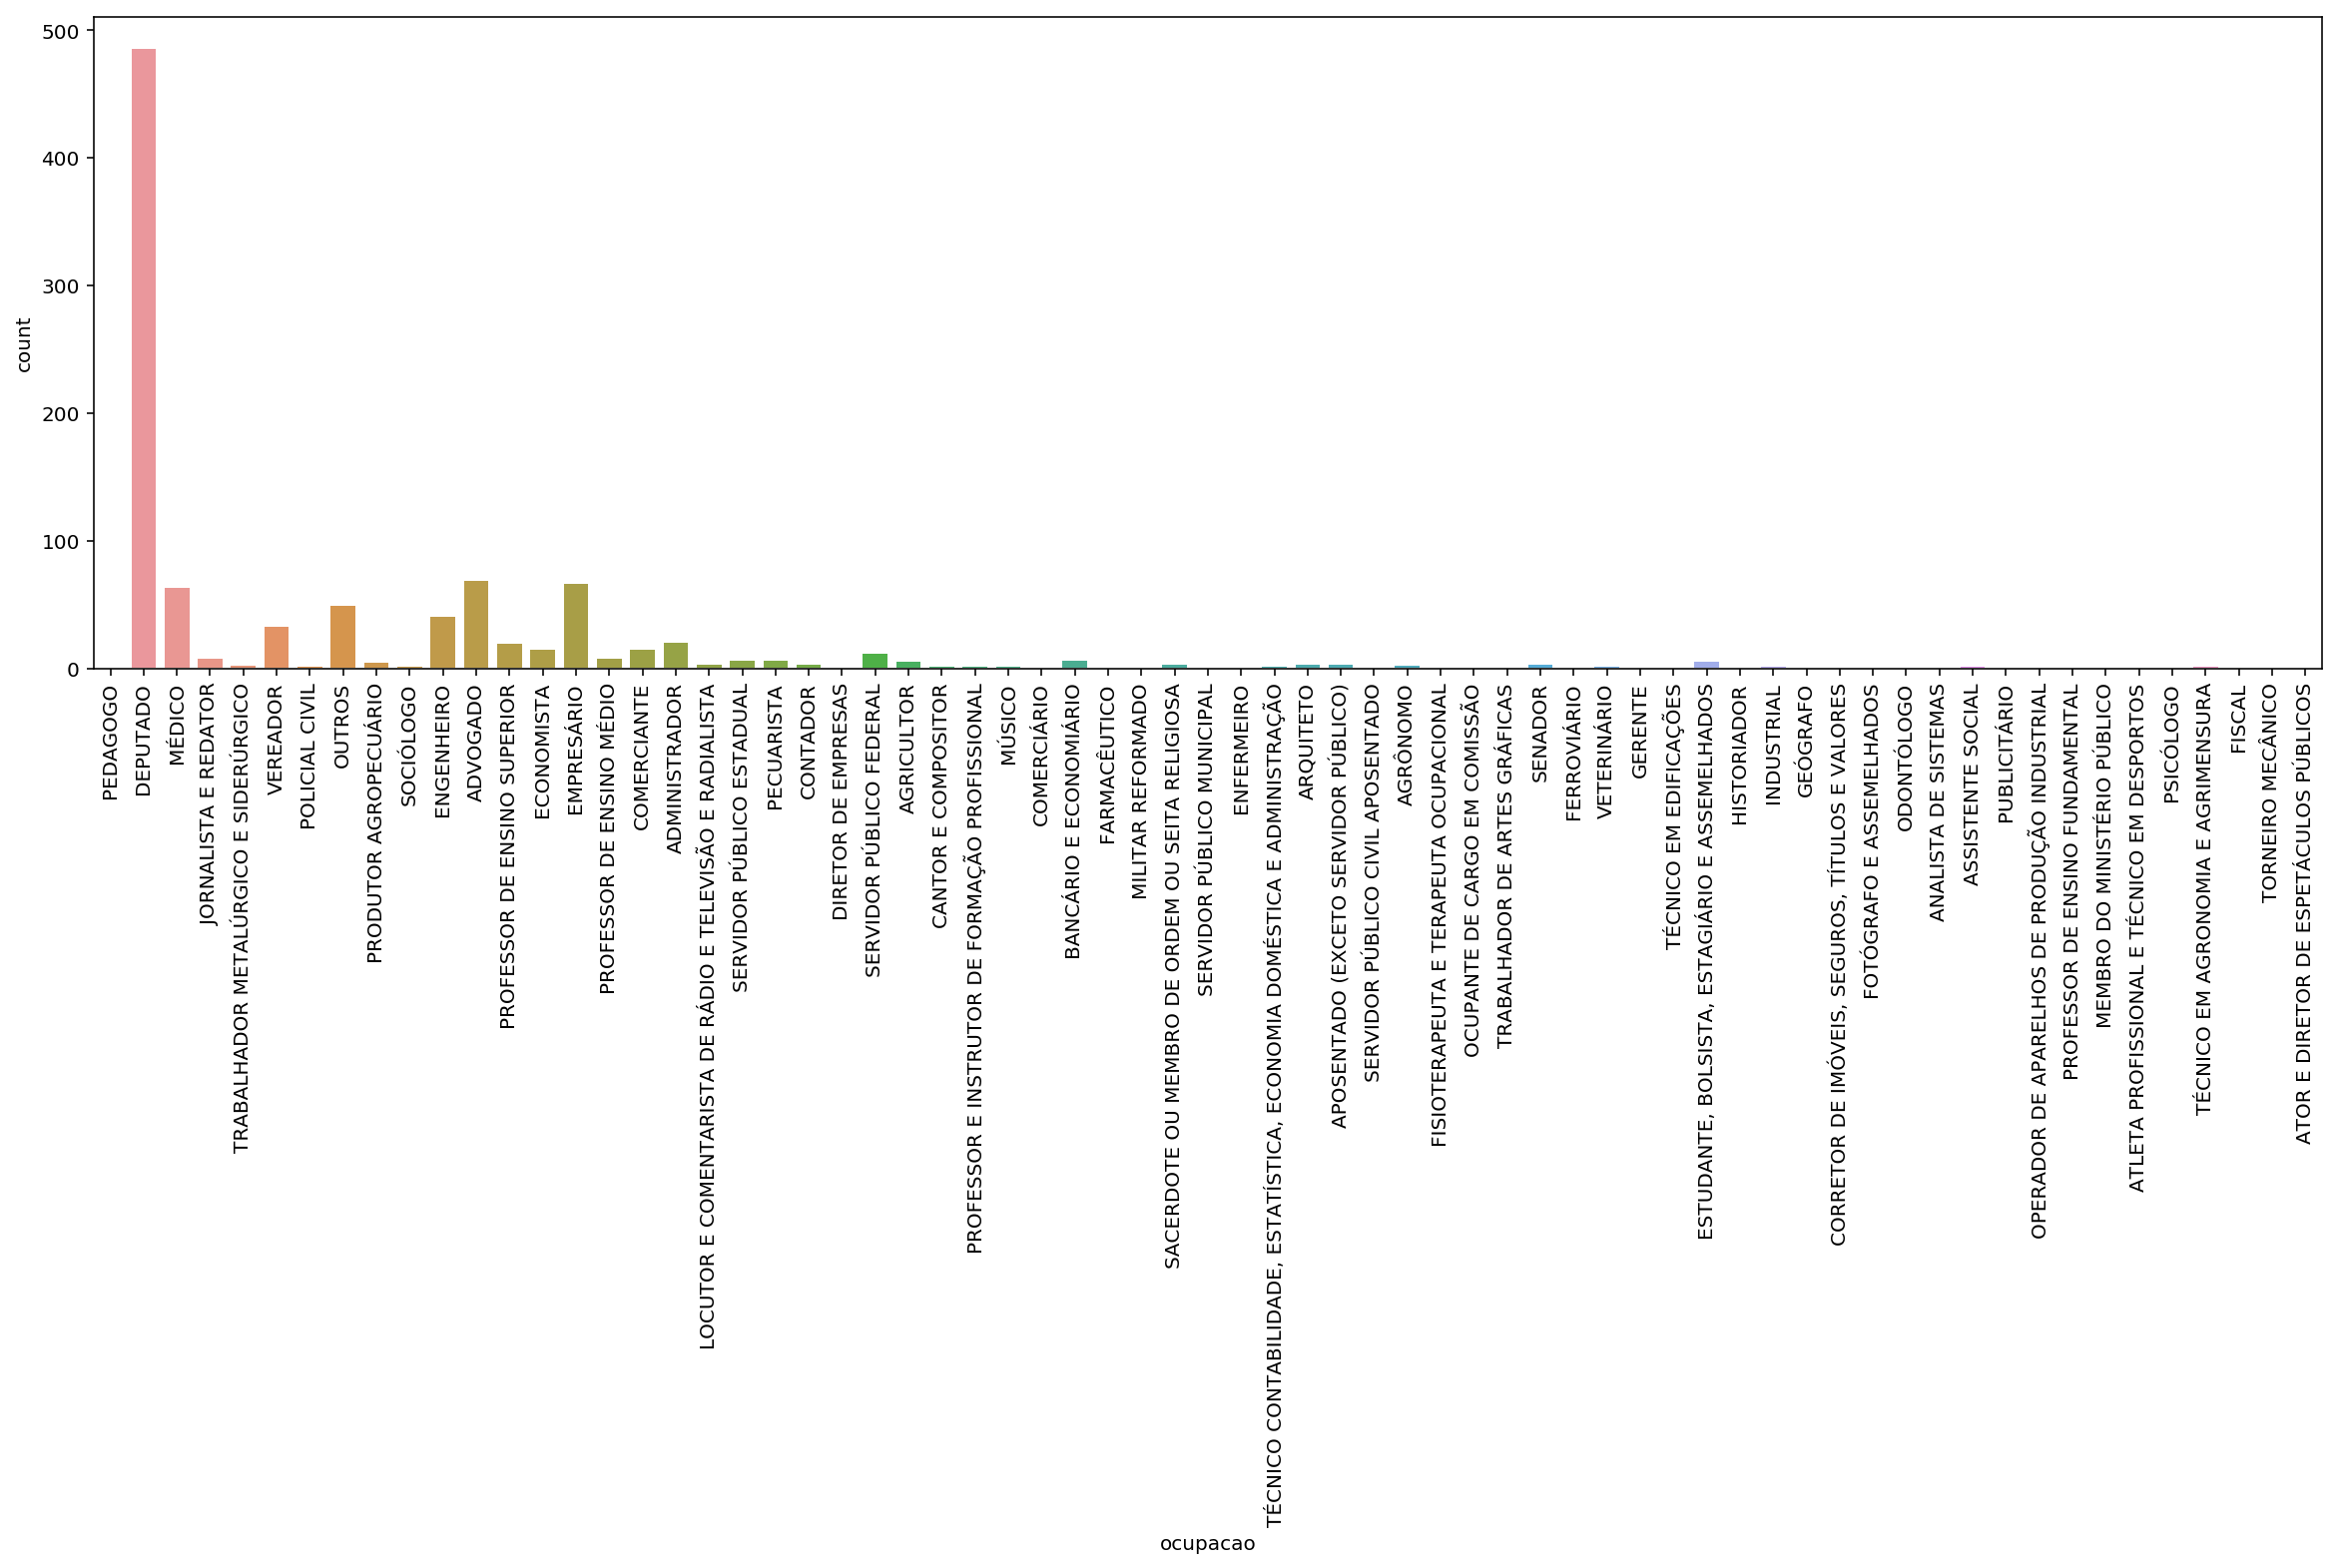

In [12]:
# Verificando a ocupacao de cada eleito
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style('whitegrid')
sns.countplot(x='ocupacao',data=eleitos)
plt.xticks(rotation=90)
plt.show()

In [13]:
ocupacao = pd.DataFrame(eleitos.ocupacao.value_counts())
ocupacao = ocupacao.reset_index()
ocupacao.columns = ['ocupacao','quantidade']
ocupacao.head()

,ocupacao,quantidade
0,DEPUTADO,486
1,ADVOGADO,69
2,EMPRESÁRIO,67
3,MÉDICO,64
4,OUTROS,50


In [14]:
treino = df1
treino['ocupacao_prop'] = 'NaN'
for i in range(0, treino.shape[0]):
    for j in range(0, ocupacao.shape[0]):
        if treino['ocupacao'][i] == ocupacao['ocupacao'][j]:
            treino['ocupacao_prop'][i] = ocupacao['quantidade'][j]
treino['ocupacao_prop'] = np.where(treino['ocupacao_prop']=='NaN', 0,treino['ocupacao_prop'])
treino['ocupacao_prop'] =  pd.to_numeric(treino['ocupacao_prop'])

/media/francinaldo/ARQUIVOS/my_python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [16]:
teste = df2
teste['ocupacao_prop'] = 'NaN'
for i in range(0, teste.shape[0]):
    for j in range(0, ocupacao.shape[0]):
        if teste['ocupacao'][i] == ocupacao['ocupacao'][j]:
            teste['ocupacao_prop'][i] = ocupacao['quantidade'][j]
teste['ocupacao_prop'] = np.where(teste['ocupacao_prop']=='NaN', 0, teste['ocupacao_prop'])
teste['ocupacao_prop'] = pd.to_numeric(teste['ocupacao_prop'])

/media/francinaldo/ARQUIVOS/my_python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Removendo os atributos que não serão utilizados

Serão removidos alguns atributos:

**cargo** -> todos os canditatos concorem ao mesmo cargo

**sequencial_candidato** -> número de sequência para identificar o candidato

**ano** -> refere-se apenas ao ano do pleito

**nome** -> nome do canditado

**ocupacao** -> substituido pelo atributo criado ocupacao_prop

In [19]:
# Removendo os atributos "cargo", "ano", "sequencial_candidato" e "nome"
train = treino.drop(['cargo','ano','sequencial_candidato','nome', 'ocupacao'], axis=1)
# Removendo os atributos "ano", "sequencial_candidato" e "nome"
test = teste.drop(['cargo','ano','sequencial_candidato','nome', 'ocupacao'], axis=1)

### Análise exploratória dos dados

In [20]:
### Verificando informações do dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7622 entries, 0 to 7621
Data columns (total 20 columns):
uf                                       7622 non-null object
partido                                  7622 non-null object
quantidade_doacoes                       7622 non-null int64
quantidade_doadores                      7622 non-null int64
total_receita                            7622 non-null float64
media_receita                            7622 non-null float64
recursos_de_outros_candidatos.comites    7622 non-null float64
recursos_de_pessoas_fisicas              7622 non-null float64
recursos_de_pessoas_juridicas            7622 non-null float64
recursos_proprios                        7622 non-null float64
recursos_de_partido_politico             7622 non-null float64
quantidade_despesas                      7622 non-null int64
quantidade_fornecedores                  7622 non-null int64
total_despesa                            7622 non-null float64
media_despesa        

In [21]:
### Verificando informações do dataset
train.shape

(7622, 20)

In [22]:
# Decrevendo as variáveis numéricas
desc_int = train.describe(include=[np.number])
desc_int.loc['count'] = desc_int.loc['count'].astype(int).astype(str)
desc_int.iloc[1:] = desc_int.iloc[1:].applymap('{:.0f}'.format)
desc_int.T

,count,mean,std,min,25%,50%,75%,max
quantidade_doacoes,7622,28,117,1,4,9,23,6997
quantidade_doadores,7622,25,102,1,3,8,21,5800
total_receita,7622,173220,444419,0,2829,13345,104668,5690642
media_receita,7622,5456,14003,0,625,1538,4666,500180
recursos_de_outros_candidatos.comites,7622,19657,104164,0,0,1125,6196,3664205
recursos_de_pessoas_fisicas,7622,23158,66892,0,0,1350,15746,1403049
recursos_de_pessoas_juridicas,7622,79217,251414,0,0,0,17259,3178226
recursos_proprios,7622,25776,149531,0,0,1122,9600,5525600
recursos_de_partido_politico,7622,25411,130861,0,0,0,0,2745700
quantidade_despesas,7622,130,411,1,6,20,80,9932


In [23]:
# Decrevendo as variáveis categóricas
cat_train = train.describe(include=[np.object])
cat_train.T

,count,unique,top,freq
uf,7622,27,SP,1679
partido,7622,31,PT,619
sexo,7622,2,MASCULINO,6544
grau,7622,7,SUPERIOR COMPLETO,4401
estado_civil,7622,5,CASADO(A),4874
situacao,7622,2,nao_eleito,6596


Número de instâncias de cada classe da variável alvo
nao_eleito    6596
eleito        1026
Name: situacao, dtype: int64


Percentual de instâncias de cada classe da variável alvo


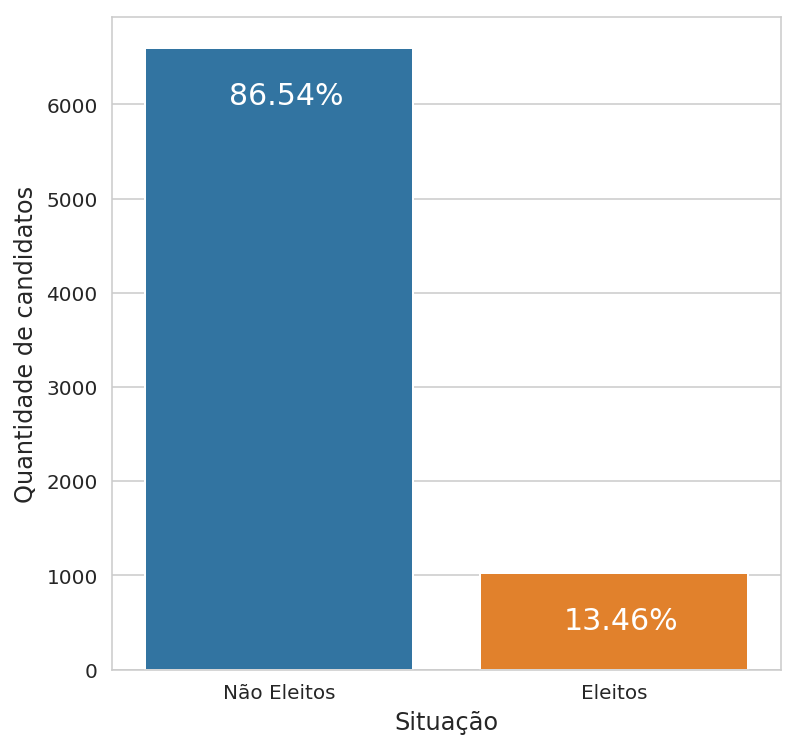

In [24]:
# Vefificando a variável alvo "situacao"
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.countplot(x='situacao',data=train)

ax.set_xlabel("Situação", fontsize=12)
ax.set_ylabel("Quantidade de candidatos", fontsize=12)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Não Eleitos', 'Eleitos'])

# Textos na barra
totals = []
for i in ax.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_x()+0.25, i.get_height()-600, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='white')
# prints    
print(color.BOLD + "Número de instâncias de cada classe da variável alvo" + color.END)
print(train.situacao.value_counts())
print(color.BOLD + "\n\nPercentual de instâncias de cada classe da variável alvo" + color.END)

Temos, então, 13.46% de casos de eleitos entre os 7622 candidatos, o que mostra um desbalanceamento de classes.

Conjuntos de dados desbalanceadas podem comprometer o desempenho da maioria dos algoritmos clássicos de classificação. Esses algoritmos assumem que as bases têm uma distribuição de exemplos equilibrada entre os grupos e que o custo por uma classificação errada é o mesmo para todas as classes (2).

De forma geral, as abordagens que têm sido propostas para a rotulação de instâncias em problemas com classes muito desbalanceadas seguem dois caminhos distintos (1). Um deles é o de atribuir custos diferenciados às classes durante a indução do modelo de classificação (3).  O outro caminho se baseia em reamostragem de dados (subamostragem ou sobreamostragem). 

Métodos de subamostragem (*undersampling*) removem elementos da classe majoritaria a fim de promover o  balanceamento. Os exemplos a serem eliminados podem ser escolhidos de forma aleatória (subamostragem aleatória) ou por meio de algum critério de seleção (subamostragem informativa), enquanto na sobreamostragem, dados da classe minoritária são replicados ou são gerados dados sintéticos.


#### Referências
1. Deepa,  T.  and  Punithavalli,  M. An analysis for mining imbalanced datasets. International Journal of Computer Science and Information Security vol. 8, pp. 132–137, 2010.

2. He, H. and Garcia, E. A. Learning from imbalanced data. IEEE Transactions on Knowledge and Data Engineering 21 (9): 1263–1284, 2009.

3. Zadrozny, B. , Langford, J., and Abe, N. Cost-sensitive learning by cost-proportionate example weighting. In Proceedings of the Third IEEE International Conference on Data Mining. ICDM ’03. IEEE Computer Society, pp. 435–, 2003.

### Pré-processamento dos dados

#### Convertendo recursos categóricos

A biblioteca do *scikit* trabalha exclusivamente com atributos numéricos. Logo, é necessário transformar os campos categóricos em variáveis *dummy* (a variável dummy é uma variável categegórica transformada em numérica). Caso contrário, nosso algoritmo de Machine Learning não aceitará esses atributos diretamente como entradas.

In [25]:
# Listando as colunas com variáveis categóricas
train.dtypes[train.dtypes == "object"].index

Index(['uf', 'partido', 'sexo', 'grau', 'estado_civil', 'situacao'], dtype='object')

In [26]:
# Variáveis categóricas que serão utilizadas como preditores
categoricas_train = pd.get_dummies(train[['uf', 'partido', 'sexo', 'grau', 
                                          'estado_civil']], drop_first=True)

In [27]:
# Criando o dataset de treino após o pré-processamento
# Removendo os atributos numéricos do dataset
temp = train.drop(['uf', 'partido', 'sexo', 'grau', 'estado_civil'], axis=1)
# Criando novo dataset com as variáveis numéricas e as variáveis dummy
df = pd.concat([temp,categoricas_train],axis=1)
# Convertendo os valores da variável alvo em numéricos (0, para não eleitos e 1 para eleitos)
df['situacao'] = np.where(df['situacao']=='eleito', 1,0)

In [28]:
### Preparando o dataset de test
categoricas_test = pd.get_dummies(test[['uf', 'partido', 'sexo', 'grau','estado_civil']], drop_first=True)
# Removendo os atributos numéricos do dataset
temp2 = test.drop(['uf', 'partido', 'sexo', 'grau', 'estado_civil'], axis=1)
# Criando novo dataset com as variáveis numéricas e as variáveis dummy
df_test = pd.concat([temp2,categoricas_test],axis=1)

In [29]:
# Verificando se há diferença de colunas após a criação das variáveis dummy
(set(df.columns) - (set(df_test.columns)))

{'partido_PAN', 'partido_PFL', 'partido_PL', 'partido_PRONA', 'situacao'}

In [30]:
# Adicionando as colunas faltantes ao dataset de treino
colunas_diff = np.array(['partido_PAN', 'partido_PFL', 'partido_PL', 'partido_PRONA'])

df_valid = pd.concat(
    [
        df_test,
        pd.DataFrame([[0,0,0,0] 
              for _ in range(df_test.shape[0])], df_test.index, colunas_diff)
    ], axis=1)

In [31]:
# Verificando se ainda há diferenças além da coluna da variável alvo
(set(df.columns) - (set(df_valid.columns)))

{'situacao'}

In [32]:
### Separando as variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

### Métricas de Classificação

Utilizaremos as seguintes méticas para a avaliação dos modelos:

#### Acurácia

   É basicamente o número de acertos (positivos) divido pelo número total de exemplos. Ela deve ser usada em datasets com a mesma proporção de exemplos para cada classe, e quando as penalidades de acerto e erro para cada classe forem as mesmas.

   Em problemas com classes desproporcionais, ela causa uma falsa impressão de bom desempenho. Por exemplo, num dataset em que 80% dos exemplos pertençam a uma classe, só de classificar todos os exemplos naquela classe já se atinge uma precisão de 80%, mesmo que todos os exemplos da outra classe estejam classificados incorretamente.

    $Acurácia = \frac{Verdadeiros Positivos (TP) + Falsos Positivos (TP)}{Total}$

#### Precisão

   Número de exemplos classificados como pertencentes a uma classe, que realmente são daquela classe (verdadeiros positivos), dividido pela soma entre este número, e o número de exemplos classificados nesta classe, mas que pertencem a outras (falsos positivos).

    $Precisão = \frac{Verdadeiros Positivos (TP)}{Verdadeiros Positivos (TP) + Falsos Positivos (TP)}$

#### Recall

   Número de exemplos classificados como pertencentes a uma classe, que realmente são daquela classe, dividido pela quantidade total de exemplos que pertencem a esta classe, mesmo que sejam classificados em outra. No caso binário, verdadeiros positivos divididos por total de positivos.

    $Recall = \frac{Verdadeiros Positivos (TP)}{Verdadeiros Positivos (TP) + Falsos Negativos (FN)}$

#### F1 Score

   O F1 Score é uma média harmônica entre precisão e recall.

   Ela é muito boa quando você possui um dataset com classes desproporcionais, e o seu modelo não emite probabilidades. Isso não significa que não possa ser usada com modelos que emitem probabilidades, tudo depende do objetivo de sua tarefa de machine learning.

   Em geral, quanto maior o F1 score, melhor.    

    $F1 Score = \frac{2 * precisão * recall}{precisão + recall}$

#### AUC – Area Under the ROC Curve

<img src="auc.png" width="300" height="300"  align="left"/> 

   Esta é uma métrica interessante para tarefas com classes desproporcionais. Nela, mede-se a área sob uma curva formada pelo gráfico entre a taxa de exemplos positivos, que realmente são positivos, e a taxa de falsos positivos.

   Uma das vantagens em relação ao F1 Score, é que ela mede o desempenho do modelo em vários pontos de corte, não necessariamente atribuindo exemplos com probabilidade maior que 50% para a classe positiva, e menor, para a classe negativa.

   Em sistemas que se interessam apenas pela classe, e não pela probabilidade, ela pode ser utilizada para definir o melhor ponto de corte para atribuir uma ou outra classe a um exemplo. Este ponto de corte normalmente é o ponto que se localiza mais à esquerda, e para o alto, no gráfico, mas depende bastante do custo do erro na previsão de uma determinada classe.
   
Fonte: http://mariofilho.com/as-metricas-mais-populares-para-avaliar-modelos-de-machine-learning/


#### Essas méticas no Scikit-Learn

*metrics.accuracy_score(y_true, y_pred[, …])* ->  Accuracy classification score.
 
*metrics.precision_score(y_true, y_pred[, …])* -> Compute the precision

*metrics.f1_score(y_true, y_pred[, labels, …])* -> Compute the F1 score, also known as balanced F-score or F-measure

*metrics.recall_score(y_true, y_pred[, …])* -> 	Compute the recall

*metrics.roc_auc_score(y_true, y_score[, …])* -> 	Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

*metrics.classification_report(y_true, y_pred)* -> 	Build a text report showing the main classification metrics

*metrics.confusion_matrix(y_true, y_pred[, …])* -> 	Compute confusion matrix to evaluate the accuracy of a classification

###  Como ler uma Matriz de Confusão

<img src="matrizConfusao.png" width="300" height="300"  align="left"/>

### Importando as bibliotecas para as métricas

In [178]:
# Importando as bibliotecas para as métricas
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, roc_auc_score, recall_score
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix, plot_learning_curves

## Construindo os modelos

### MODELO 01  - Regressão Logística (sem balanceamento de classes)

Primeiramente vamos criar um modelo de regressão logística simples sem balanceamento de classes para vermos como se comporta

In [155]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

#### Divisão treino-teste

In [156]:
from sklearn.model_selection import train_test_split
# Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

#### Treino e predição

In [189]:
from sklearn.linear_model import LogisticRegression
# Treinando o modelo
logit = LogisticRegression(solver='lbfgs', max_iter=400)
# Fit do modelo
logit.fit(X_train,y_train)
# Predição do modelo
logit_pred = logit.predict(X_test)

#### Avaliação do modelo

Acurácia do modelo: 0.9
Precision: 0.68
F1 do modelo: 0.57
Recall do modelo: 0.49
AUC: 0.73

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1984
           1       0.68      0.49      0.57       303

   micro avg       0.90      0.90      0.90      2287
   macro avg       0.80      0.73      0.76      2287
weighted avg       0.89      0.90      0.89      2287


Matriz de confusão
[[1913   71]
 [ 155  148]]


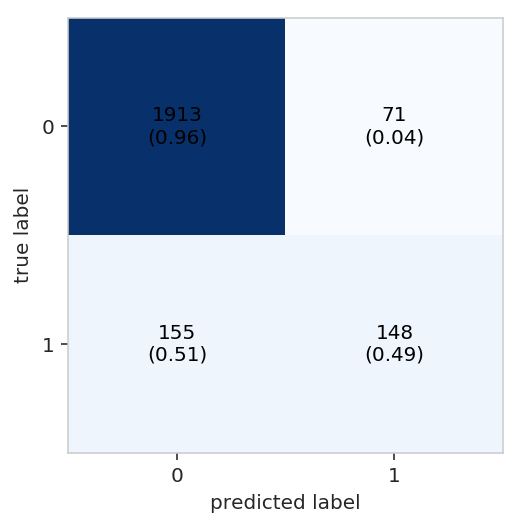

In [191]:
# Métricas
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,logit_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,logit_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,logit_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,logit_pred),2)))
print(color.BOLD + 'AUC: ' + color.END + str(round(roc_auc_score(y_test,logit_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,logit_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,logit_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm, show_normed=True)

plt.show()

#### Importância dos Atributos

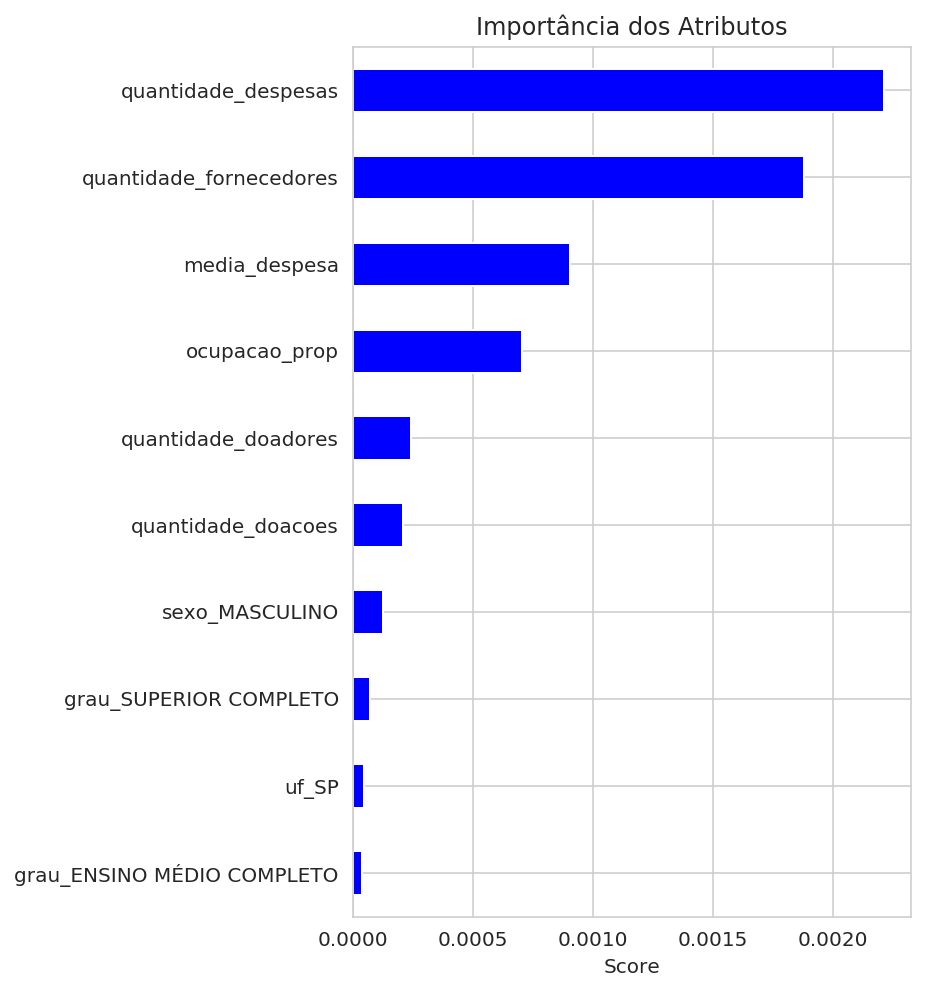

In [192]:
# Coeficientes - Logistic Regression
coef_logit = pd.DataFrame((logit.coef_[0]), index = X_train.columns.values, columns=['Coefficient'])
coef_logit = coef_logit.sort_values(by='Coefficient', ascending=False)

# Importância dos Atributos
preditores=list(X_train)
feat_score = abs(logit.coef_[0])
feat_imp = pd.Series(feat_score, preditores).sort_values(ascending=False)
#Plot
plt.subplots(figsize=(5, 8))
feat_imp.head(10).plot(kind='barh', title='Importância dos Atributos', color='blue')
plt.xlabel('Score')
plt.gca().invert_yaxis()

Verificamos que no modelo Logistic Regression os atributos mais importantes são os acima listado em ordem decrescente de importância.

#### Desempenho treino/teste

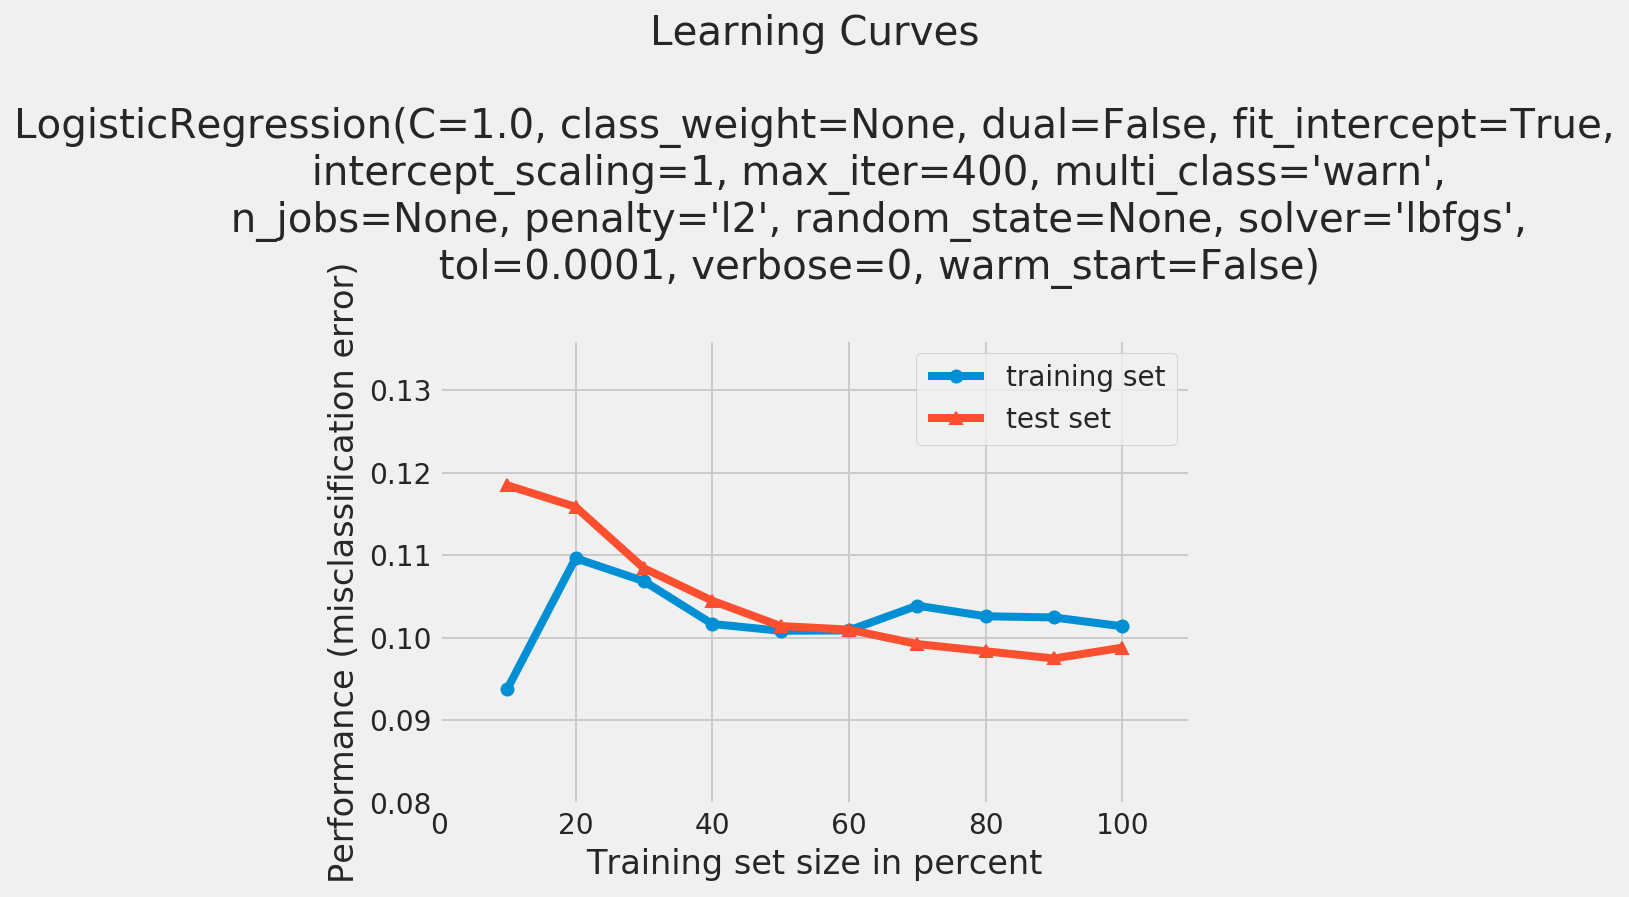

In [190]:
plot_learning_curves(X_train,y_train, X_test, y_test, logit)
plt.show()

O modelo está seguindo o mesmo padrão tanto para os dados de teste como para os de validação, isso significa que não temos overfitting (o modelo parece ter generalizado bem). No entanto o erro é considerável para os dois conjuntos e as curvas se achatam muito rapidamente, nos parecendo que há underfitting.

### MODELO 02  - Regressão Logística (com balanceamento de classes)

Para esse modelo utilizaremos o balanceamento de classes:

1. Informando à regressão logística que existe um desbalanceamento.
2. Classe minoritária (Up-sample)
3. Classe majoritária (Down-sample)

In [42]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

#### Divisão treino-teste

In [43]:
from sklearn.model_selection import train_test_split
# Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

### Informando à regressão logística que existe um desbalanceamento.

#### Treino e predição

In [193]:
from sklearn.linear_model import LogisticRegression
# Treinando o modelo
# Informamos ao algoritmo que as classes estão desbalanceadas através do parámetro class_weight='balanced'
logitb1 = LogisticRegression(solver='lbfgs', max_iter=400, class_weight='balanced',random_state=101)
# Fit do modelo
logitb1.fit(X_train,y_train)
# Predição do modelo
logitb1_pred = logitb1.predict(X_test)

#### Avaliação do modelo

Acurácia do modelo: 0.65
Precision: 0.27
F1 do modelo: 0.42
Recall do modelo: 0.95
AUC: 0.78

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      1984
           1       0.27      0.95      0.42       303

   micro avg       0.65      0.65      0.65      2287
   macro avg       0.63      0.78      0.58      2287
weighted avg       0.89      0.65      0.71      2287


Matriz de confusão
[[1200  784]
 [  15  288]]


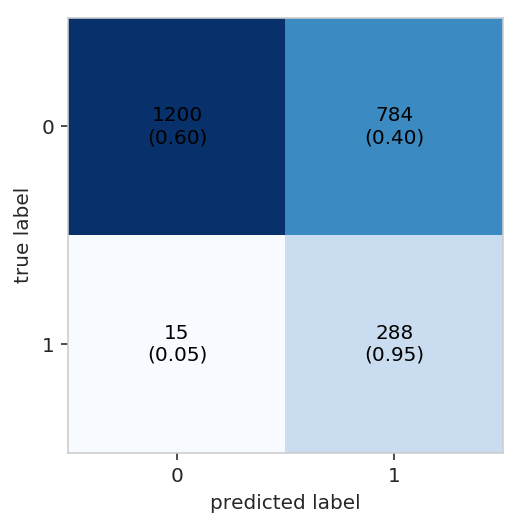

In [194]:
# Métricas
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,logitb1_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,logitb1_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,logitb1_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,logitb1_pred),2)))
print(color.BOLD + 'AUC: ' + color.END + str(round(roc_auc_score(y_test,logitb1_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,logitb1_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,logitb1_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm, show_normed=True)

plt.show()

#### Importância dos Atributos

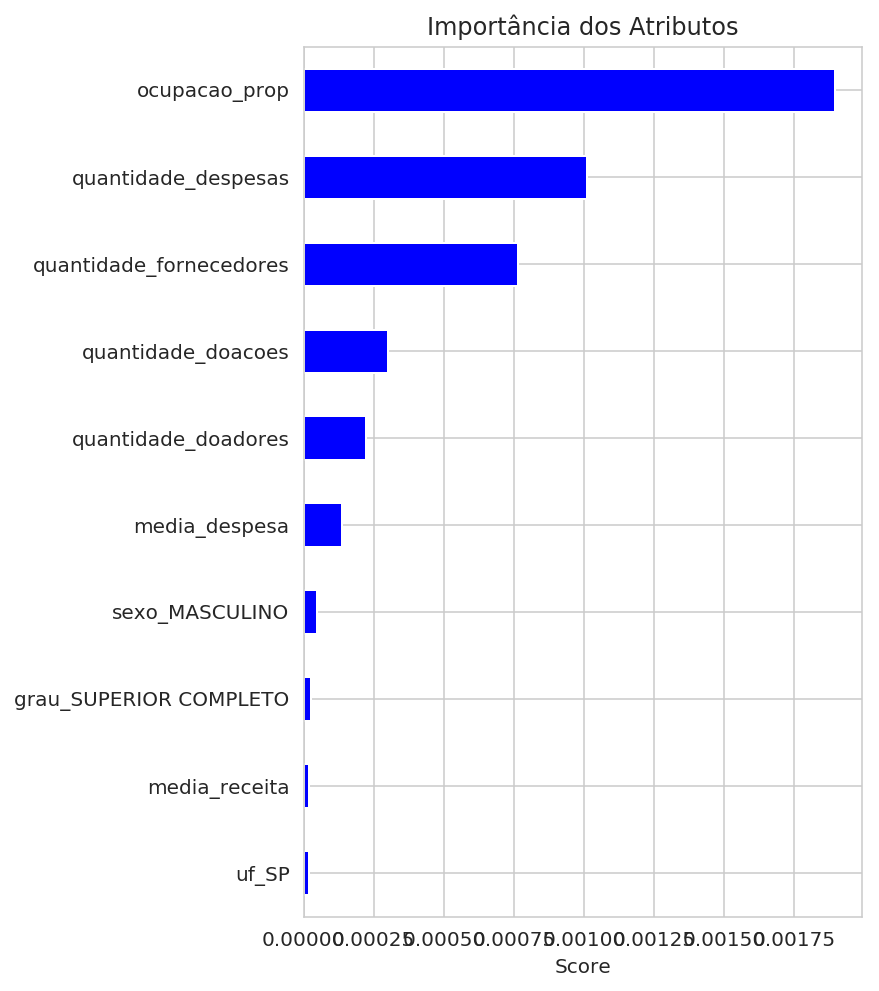

In [46]:
# Coeficientes - Logistic Regression
coef_logitb1 = pd.DataFrame((logitb1.coef_[0]), index = X_train.columns.values, columns=['Coefficient'])
coef_logitb1 = coef_logitb1.sort_values(by='Coefficient', ascending=False)

# Importância dos Atributos
preditores=list(X_train)
feat_score = abs(logitb1.coef_[0])
feat_imp = pd.Series(feat_score, preditores).sort_values(ascending=False)
#Plot
plt.subplots(figsize=(5, 8))
feat_imp.head(10).plot(kind='barh', title='Importância dos Atributos', color='blue')
plt.xlabel('Score')
plt.gca().invert_yaxis()

Verificamos que no modelo *Logistic Regression* os atributos mais importantes são os acima listado em ordem decrescente de importância.

### Classe minoritária (Up-sample)

Up-sampling é o processo de duplicação aleatória de observações da classe minoritária, a fim de reforçar seu sinal.

Existem várias heurísticas para fazê-lo, mas a maneira mais comum é simplesmente relançar com a substituição.

In [47]:
# Bliblioteca necessária 
from sklearn.utils import resample

In [48]:
# Quantidade por classe
df.situacao.value_counts()

0    6596
1    1026
Name: situacao, dtype: int64

In [49]:
# Separandos as classes majoritária e minoritária
df_majority = df[df.situacao==0]
df_minority = df[df.situacao==1]
 
# Classe minoritária -  Upsample
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # reamostragem com substituição
                                 n_samples=6596,   # para corresponder com a classe majoritária
                                 random_state=101) # para reproduzir os mesmos resultados
 
# Combine a classe majoritária com a classe minoritária upsampled
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Exibir a nova contagem da nova classe
df_upsampled.situacao.value_counts()

1    6596
0    6596
Name: situacao, dtype: int64

In [50]:
# Separando os atributos de entrada (X) e a variável alvo (y)
X = df_upsampled.drop('situacao', axis=1)
y = df_upsampled.situacao

from sklearn.model_selection import train_test_split
# Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

# Treinando o modelo
logit_up = LogisticRegression(solver='liblinear')
# Fit do modelo
logit_up.fit(X_train,y_train)
# Predição do modelo
logit_up_pred = logit_up.predict(X_test)

#### Avaliação do modelo

Acurácia do modelo: 0.78
Precision: 0.71
F1 do modelo: 0.81
Recall do modelo: 0.95
AUC: 0.78

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.92      0.61      0.74      1967
           1       0.71      0.95      0.81      1991

   micro avg       0.78      0.78      0.78      3958
   macro avg       0.82      0.78      0.77      3958
weighted avg       0.82      0.78      0.78      3958


Matriz de confusão
[[1201  766]
 [  98 1893]]


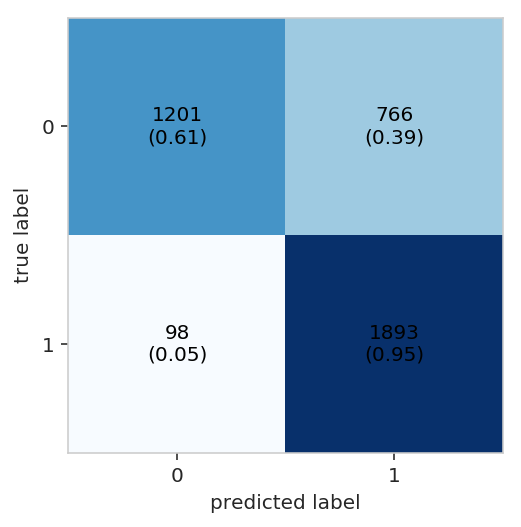

In [51]:
# Métricas
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,logit_up_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,logit_up_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,logit_up_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,logit_up_pred),2)))
print(color.BOLD + 'AUC: ' + color.END + str(round(roc_auc_score(y_test,logit_up_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,logit_up_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,logit_up_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm, show_normed=True)

plt.show()

Mesmo a abordagem tendo melhorando consideravelmente a predição do modelo ela não se mostrou eficiente para o dataset de 2014, pois deveríamos ter algo próximo de 513 eleitos

### Down-sample da classe majoritária

Down-sampling envolve a remoção aleatória de observações da classe majoritária para evitar que seu sinal domine o algoritmo de aprendizado.

A heurística mais comum para fazer isso é a reamostragem sem substituição.

O processo é semelhante ao de up-sampling. Aqui estão os passos:

1. Primeiro, vamos separar as observações de cada classe em diferentes DataFrames.
2. Em seguida, faremos uma nova amostra da classe majoritária sem substituição , definindo o número de amostras para corresponder à classe minoritária.
3. Por fim, combinaremos a classe majoritária com amostragem reduzida à classe minoritária original DataFrame.

In [53]:
# Separandos as classes majoritária e minoritária
df_majority = df[df.situacao==0]
df_minority = df[df.situacao==1]
 
# Downsample da classe mojoritáia
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # reamostragem sem substituição
                                 n_samples=1026,   # para corresponder com a classe majoritária
                                 random_state=101) # para reproduzir os mesmos resultados
 
# Combina a classe minoritária com o downsampled da classe majoritária
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Exibir a nova contagem da nova classe
df_downsampled.situacao.value_counts()

1    1026
0    1026
Name: situacao, dtype: int64

In [54]:
# Separando os atributos de entrada (X) e a variável alvo (y)
y = df_downsampled.situacao
X = df_downsampled.drop('situacao', axis=1)

from sklearn.model_selection import train_test_split
# Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

# Treinando o modelo
logit_down = LogisticRegression(solver='liblinear')
# Fit do modelo
logit_down.fit(X_train,y_train)
# Predição do modelo
logit_down_pred = logit_up.predict(X_test)

#### Avaliação do modelo

Acurácia do modelo: 0.77
Precision: 0.7
F1 do modelo: 0.81
Recall do modelo: 0.95
AUC: 0.77

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       309
           1       0.70      0.95      0.81       307

   micro avg       0.77      0.77      0.77       616
   macro avg       0.81      0.77      0.77       616
weighted avg       0.81      0.77      0.77       616


Matriz de confusão
[[185 124]
 [ 15 292]]


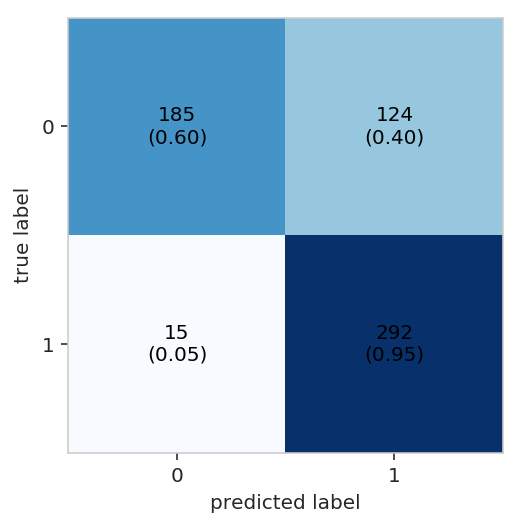

In [55]:
# Métricas
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,logit_down_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,logit_down_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,logit_down_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,logit_down_pred),2)))
print(color.BOLD + 'AUC: ' + color.END + str(round(roc_auc_score(y_test,logit_down_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,logit_down_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,logit_down_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm, show_normed=True)

plt.show()

O *downsample* teve um desempenho inferior ao *upsample* e, assim como a abordagem anterior, não se mostrou eficiente para o dataset de 2014, pois deveríamos ter algo próximo de 513 eleitos

### Uma abordagem reavaliando os dados para o equilibrio das classes

In [57]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

In [58]:
from sklearn.model_selection import train_test_split
# Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

In [59]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

pipe = make_pipeline(
    SMOTE(),
    LogisticRegression(solver='lbfgs', max_iter=200)
)

# Fitando
pipe.fit(X_train, y_train)

# Predição
pipe_pred = pipe.predict(X_test)

Acurácia do modelo: 0.7
Precision: 0.3
F1 do modelo: 0.45
Recall do modelo: 0.91
AUC ROC: 0.79

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1984
           1       0.30      0.91      0.45       303

   micro avg       0.70      0.70      0.70      2287
   macro avg       0.64      0.79      0.62      2287
weighted avg       0.89      0.70      0.75      2287


Matriz de confusão
[[1331  653]
 [  28  275]]


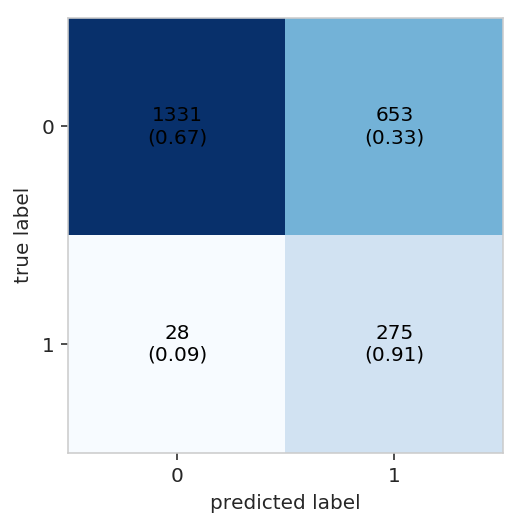

In [60]:
# Avaliando o modelo
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,pipe_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,pipe_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,pipe_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,pipe_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,pipe_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,pipe_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,pipe_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm, show_normed=True)

plt.show()

Essa abordagem também não se mostrou eficiente para a predição do dataset de 2014

### MODELO 03  - KNN

In [62]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

In [63]:
# Dividindo os dados em um conjunto de treinamento e conjunto de testes.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

In [64]:
# Carregando a biblioteca para a criação do modelo
from sklearn.neighbors import KNeighborsClassifier

In [65]:
# Modelo com apenas um vizinho
knn = KNeighborsClassifier(n_neighbors=1)

In [66]:
# Fitando o modelo
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [67]:
# Predição do modelo
knn_pred = knn.predict(X_test)

Acurácia do modelo: 0.88
Precision: 0.58
F1 do modelo: 0.57
Recall do modelo: 0.56
AUC ROC: 0.75

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1965
           1       0.58      0.56      0.57       322

   micro avg       0.88      0.88      0.88      2287
   macro avg       0.75      0.75      0.75      2287
weighted avg       0.88      0.88      0.88      2287


Matriz de confusão
[[1832  133]
 [ 142  180]]


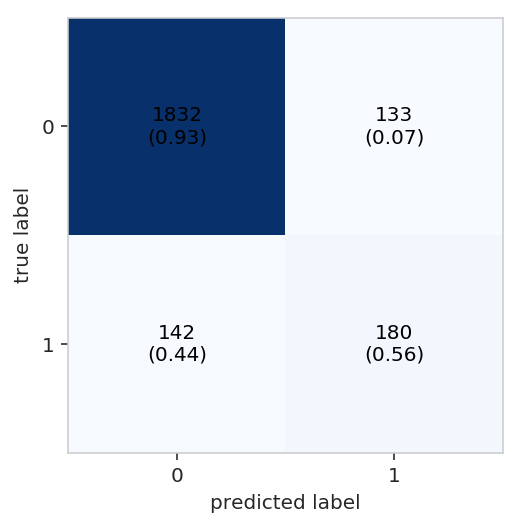

In [68]:
# Avaliando o modelo
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,knn_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,knn_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,knn_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,knn_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,knn_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,knn_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,knn_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm, show_normed=True)

plt.show()

In [69]:
# Predicão do dataset de validação
test_pred = knn.predict(df_valid)
# Dataset para apresentação
previsao = teste.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = test_pred
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==1, 'eleito','nao_eleito')
#previsao.head(10)
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    3986
eleito         606
Name: Predicted, dtype: int64

In [70]:
# Verificando qual o melhor número de vizinhos
error_rate = []

# Levará algum tempo
for i in range(1,50):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

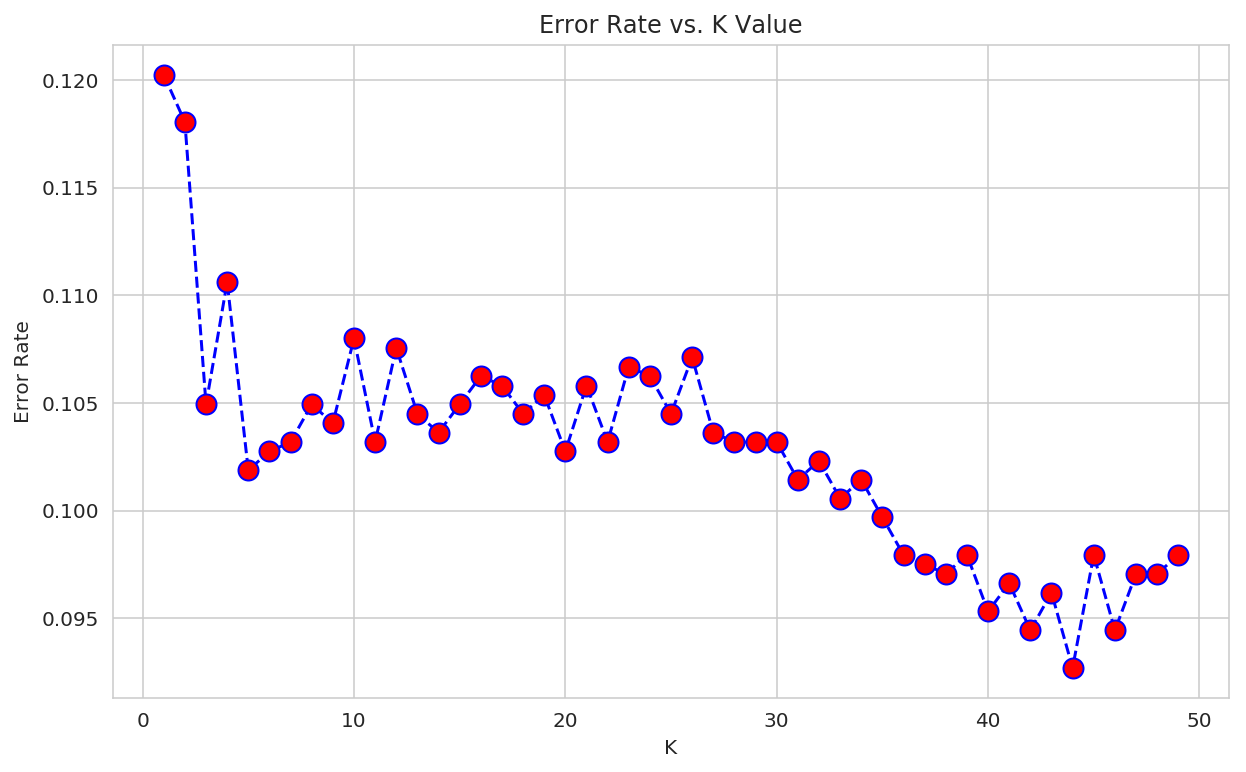

In [71]:
# Plotando a figura
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [72]:
# Agora com K=45
knn = KNeighborsClassifier(n_neighbors=45)
# Fitando o modelo
knn.fit(X_train,y_train)
# Predições
knn_pred = knn.predict(X_test)

Acurácia do modelo: 0.9
Precision: 0.67
F1 do modelo: 0.64
Recall do modelo: 0.61
AUC ROC: 0.78

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1965
           1       0.67      0.61      0.64       322

   micro avg       0.90      0.90      0.90      2287
   macro avg       0.80      0.78      0.79      2287
weighted avg       0.90      0.90      0.90      2287


Matriz de confusão
[[1866   99]
 [ 125  197]]


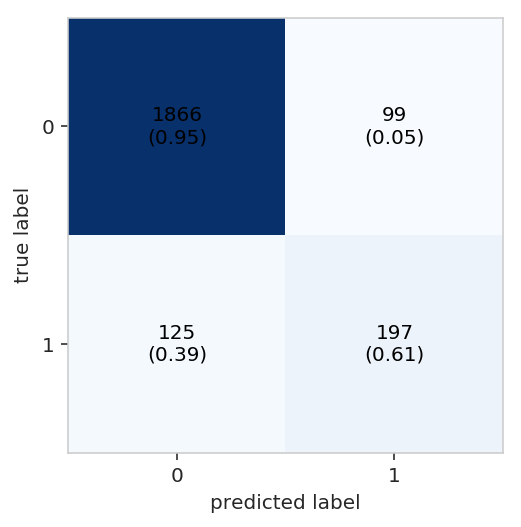

In [73]:
# Avaliando o modelo
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,knn_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,knn_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,knn_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,knn_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,knn_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,knn_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,knn_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm, show_normed=True)

plt.show()

##### Desempenho treino/teste

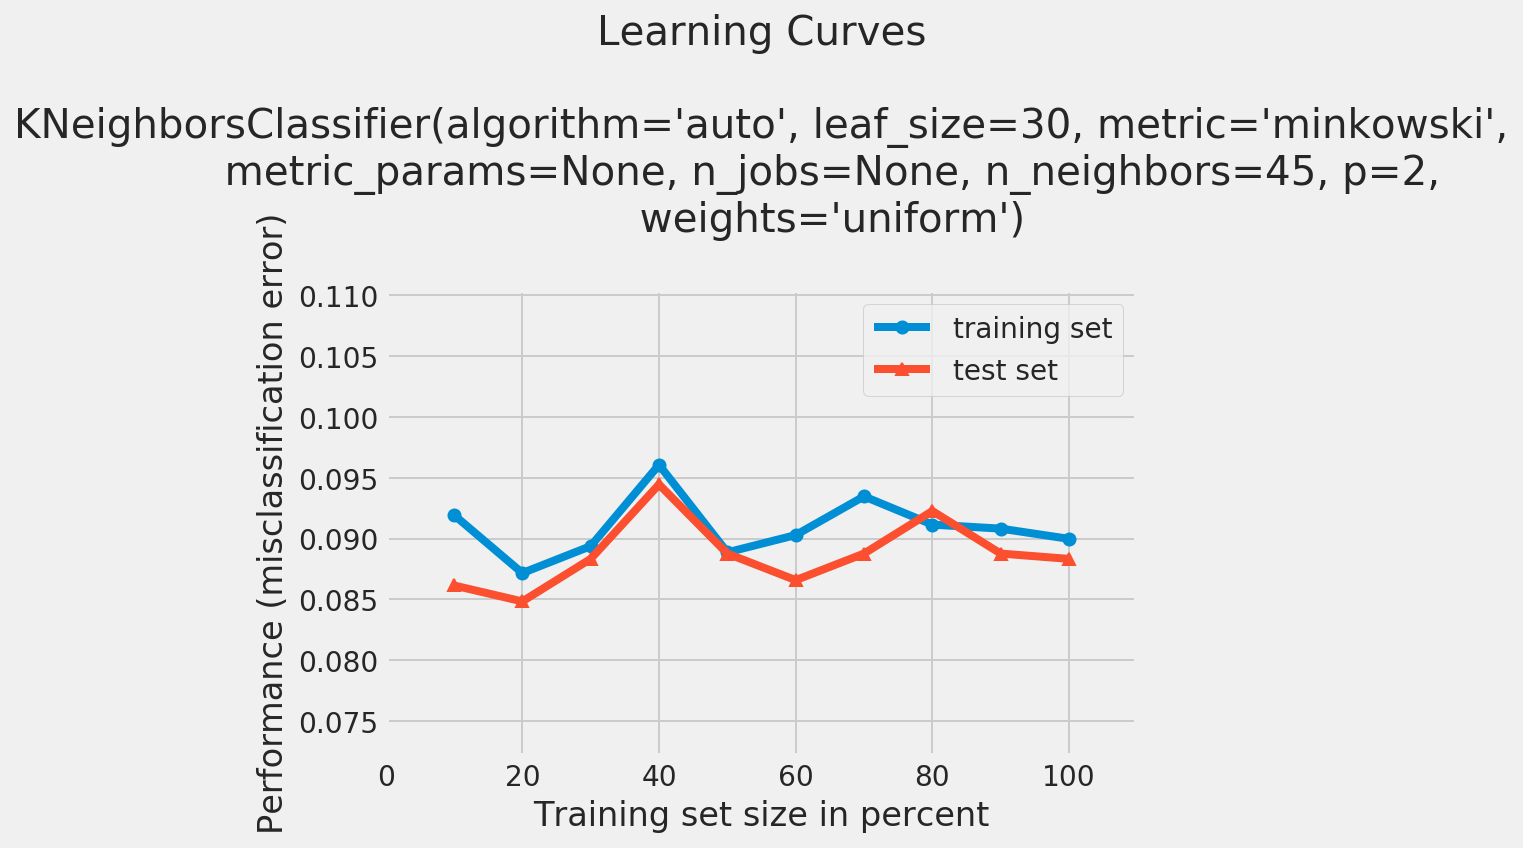

In [196]:
plot_learning_curves(X_train,y_train, X_test, y_test, knn)
plt.show()

#### Predicão do dataset de 2014

In [74]:
# Predicão do dataset de validação
test_pred = knn.predict(df_valid)
# Dataset para apresentação
previsao = teste.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = test_pred
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==1, 'eleito','nao_eleito')
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    3976
eleito         616
Name: Predicted, dtype: int64

### MODELO 04 - Árvores de Decisão

In [198]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

In [199]:
# Dividindo os dados em um conjunto de treinamento e conjunto de testes.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

In [200]:
# Biblioteca para o modelo
from sklearn.tree import DecisionTreeClassifier

In [201]:
# Criando o modelo
dtree = DecisionTreeClassifier()
# Fitando o modelo
dtree.fit(X_train,y_train)
# Predição
dtree_pred= dtree.predict(X_test)

Acurácia do modelo: 0.89
Precision: 0.64
F1 do modelo: 0.62
Recall do modelo: 0.61
AUC ROC: 0.78

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1960
           1       0.64      0.61      0.62       327

   micro avg       0.89      0.89      0.89      2287
   macro avg       0.79      0.78      0.78      2287
weighted avg       0.89      0.89      0.89      2287


Matriz de confusão
[[1846  114]
 [ 127  200]]


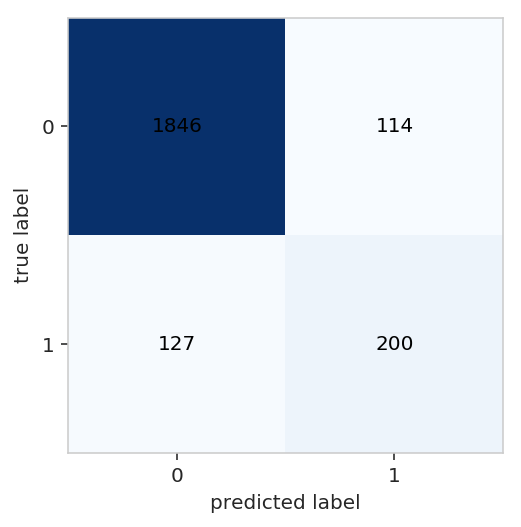

In [202]:
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,dtree_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,dtree_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,dtree_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,dtree_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,dtree_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,dtree_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,dtree_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm)

plt.show()

#### Desempenho treino/teste

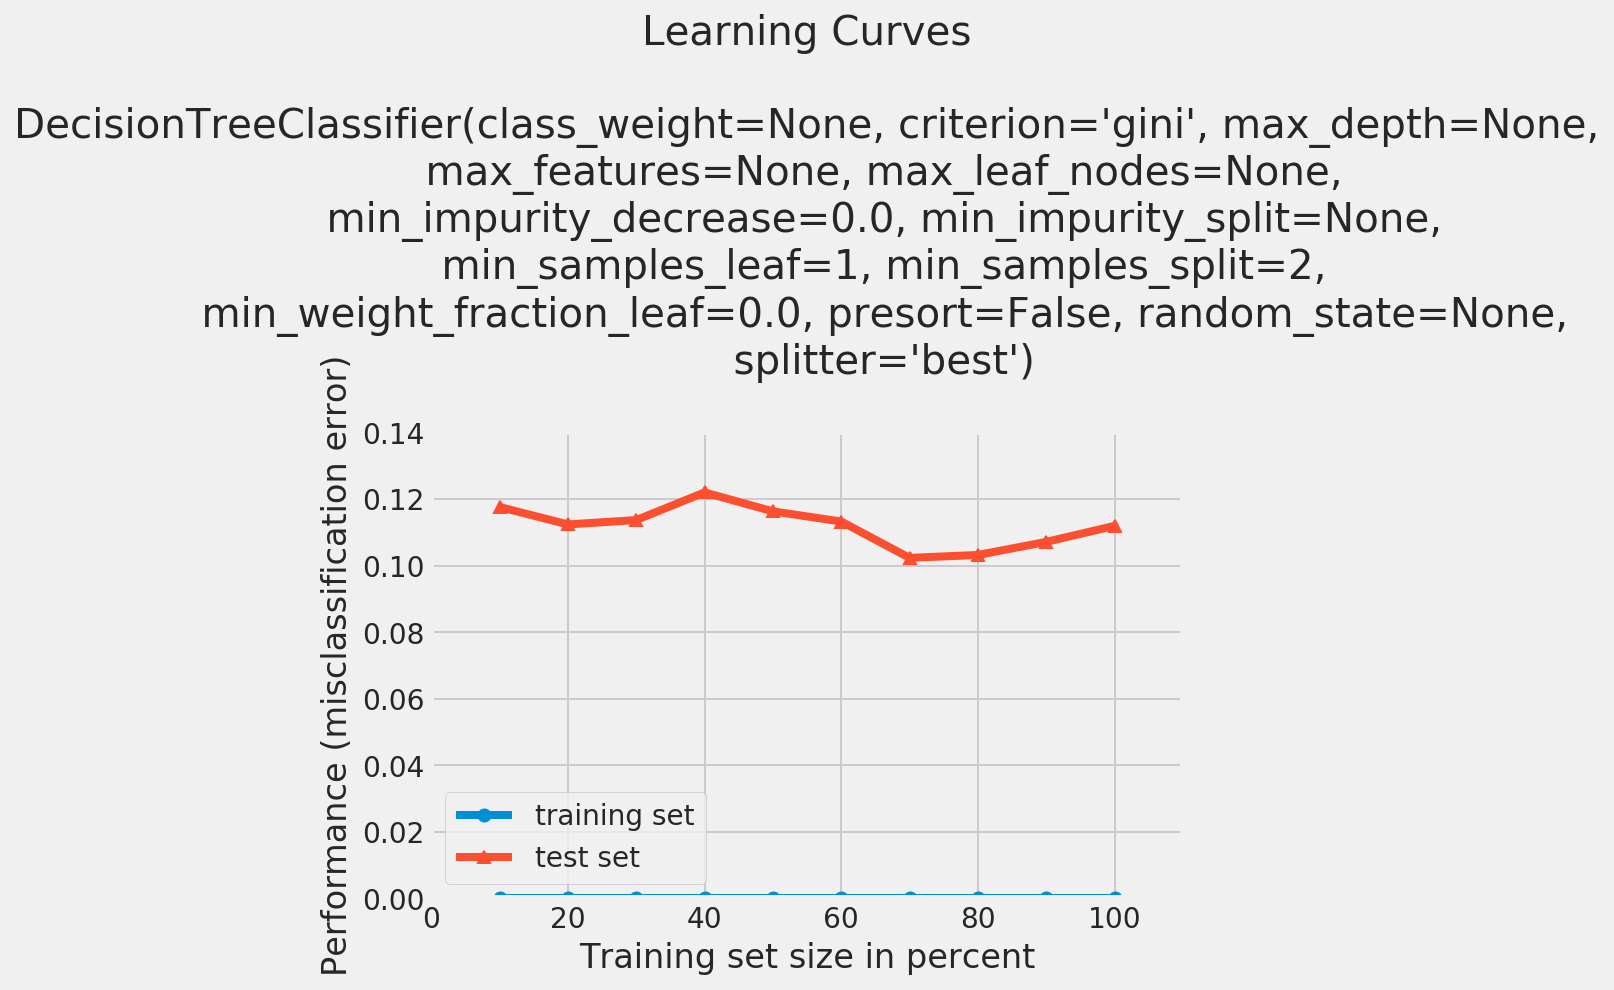

In [203]:
plot_learning_curves(X_train,y_train, X_test, y_test, dtree)
plt.show()

Aqui vemos que o erro no conjunto de treinamento começa e permanece extremamente baixo, enquanto o erro no conjunto de teste é grande. Parece que o erro do conjunto de teste está diminuindo lentamente com mais dados. Isso é característico do overfitting, o modelo está capturando exatamente o comportamento dos dados de treinamento, e, portanto, não está conseguindo generalizar para novos pontos.

#### Predicão do dataset de validação

In [204]:
# Predicão do dataset de validação
test_pred = dtree.predict(df_valid)
# Dataset para apresentação
previsao = teste.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = test_pred
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==1, 'eleito','nao_eleito')
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    3933
eleito         659
Name: Predicted, dtype: int64

### MODELO 05 - AdaBoostClassifier

In [205]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

In [206]:
# Dividindo os dados em um conjunto de treinamento e conjunto de testes.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

In [207]:
# Biblioteca para o modelo
from sklearn.ensemble import AdaBoostClassifier

In [208]:
# Criando o modelo
ada = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1,
                         random_state=0)
# Fitando o modelo
ada.fit(X_train,y_train)
# Predição
ada_pred = ada.predict(X_test)

Acurácia do modelo: 0.92
Precision: 0.75
F1 do modelo: 0.7
Recall do modelo: 0.66
AUC ROC: 0.81

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1948
           1       0.75      0.66      0.70       339

   micro avg       0.92      0.92      0.92      2287
   macro avg       0.85      0.81      0.83      2287
weighted avg       0.91      0.92      0.92      2287


Matriz de confusão
[[1875   73]
 [ 115  224]]


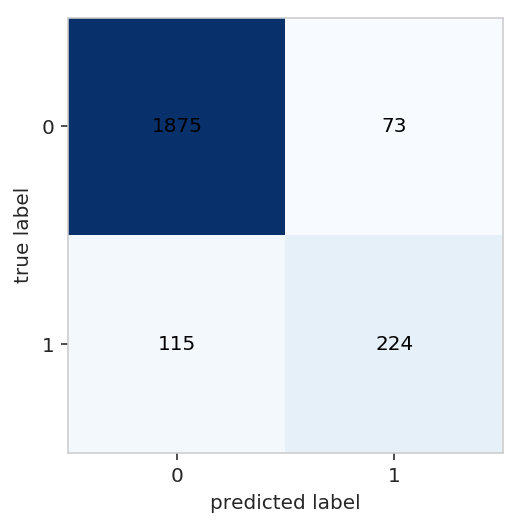

In [209]:
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,ada_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,ada_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,ada_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,ada_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,ada_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,ada_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,ada_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm)

plt.show()

#### Desempenho treino/teste

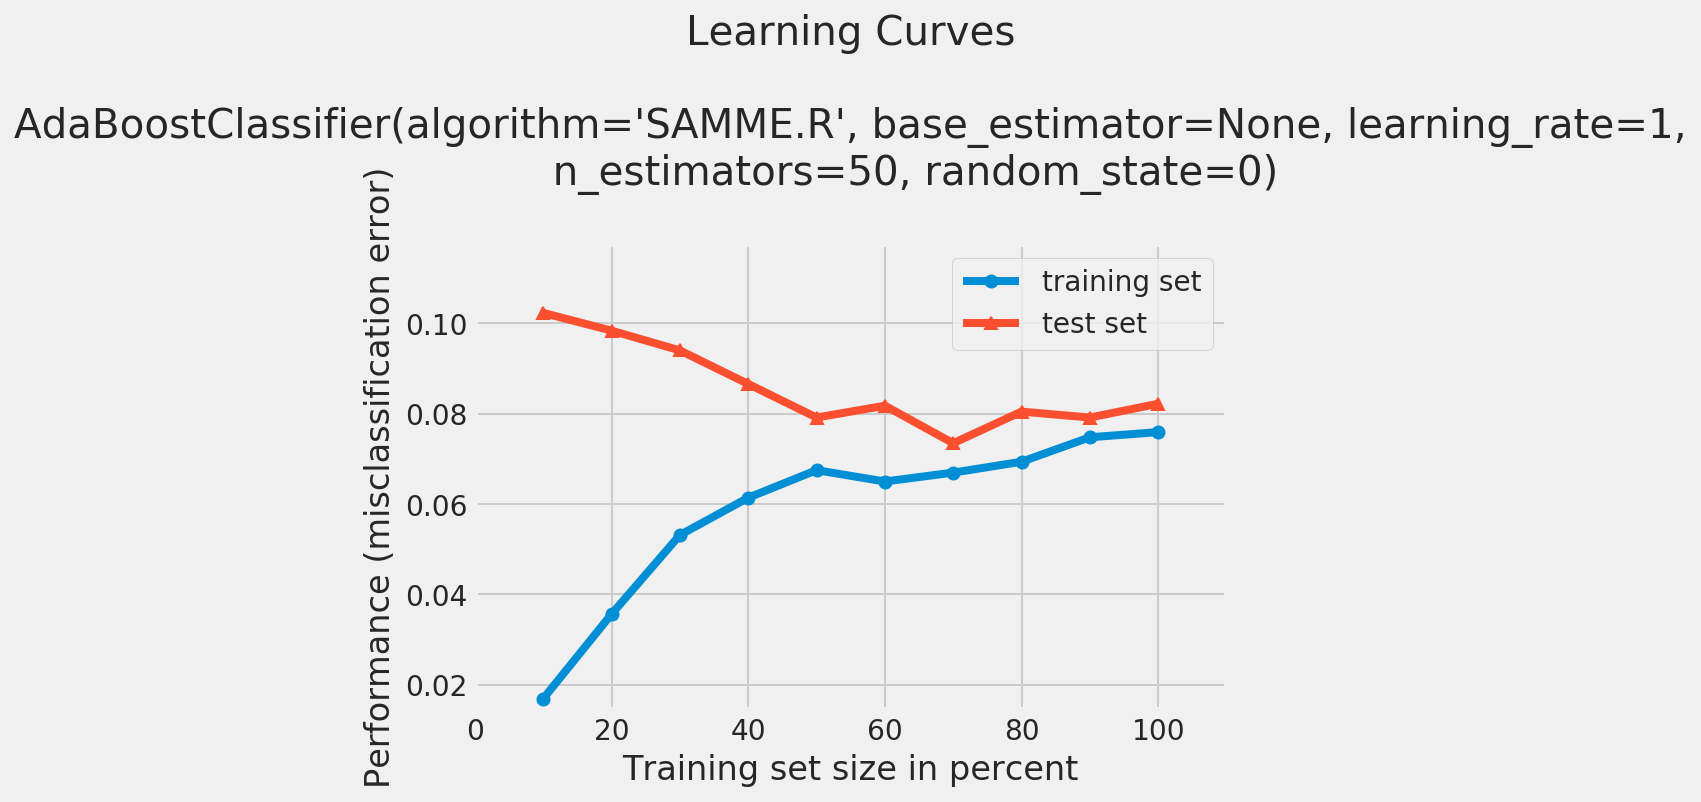

In [210]:
plot_learning_curves(X_train,y_train, X_test, y_test, ada)
plt.show()

Após usar todos os dados de treinamento, o modelo está fazendo o mesmo no conjunto de teste e de treinamento - isso significa que não temos overfitting (o modelo generalizou bem). Por outro lado, em termos absolutos, o erro é alto para treinamento e teste. As curvas se achataram muito rapidamente e parece termos aqui underfitting.

#### Predicão do dataset de validação

In [211]:
# Predicão do dataset de validação
test_pred = ada.predict(df_valid)
# Dataset para apresentação
previsao = teste.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = test_pred
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==1, 'eleito','nao_eleito')
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    4151
eleito         441
Name: Predicted, dtype: int64

### MODELO 06 - RandomForestClassifier

In [212]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

In [213]:
# Dividindo os dados em um conjunto de treinamento e conjunto de testes.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

In [214]:
# Biblioteca para o modelo
from sklearn.ensemble import RandomForestClassifier

In [215]:
# Criando o modelo
rfc = RandomForestClassifier(n_estimators=600)
# Fitando o modelo
rfc.fit(X_train,y_train)
# Predição
rfc_pred = rfc.predict(X_test)

Acurácia do modelo: 0.91
Precision: 0.7
F1 do modelo: 0.69
Recall do modelo: 0.68
AUC ROC: 0.82

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1968
           1       0.70      0.68      0.69       319

   micro avg       0.91      0.91      0.91      2287
   macro avg       0.82      0.82      0.82      2287
weighted avg       0.91      0.91      0.91      2287


Matriz de confusão
[[1873   95]
 [ 102  217]]


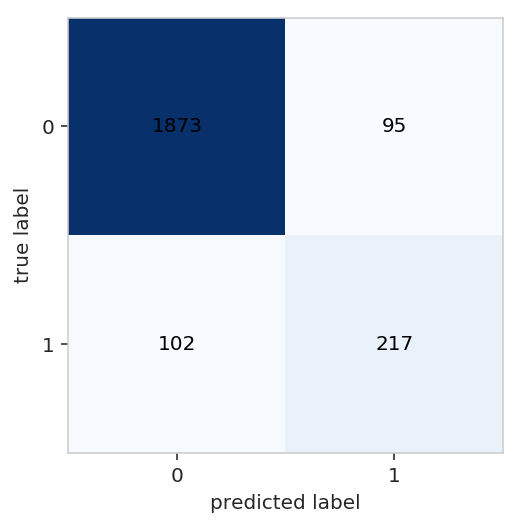

In [216]:
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,rfc_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,rfc_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,rfc_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,rfc_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,rfc_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,rfc_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,rfc_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm)

plt.show()

#### Desempenho treino/teste

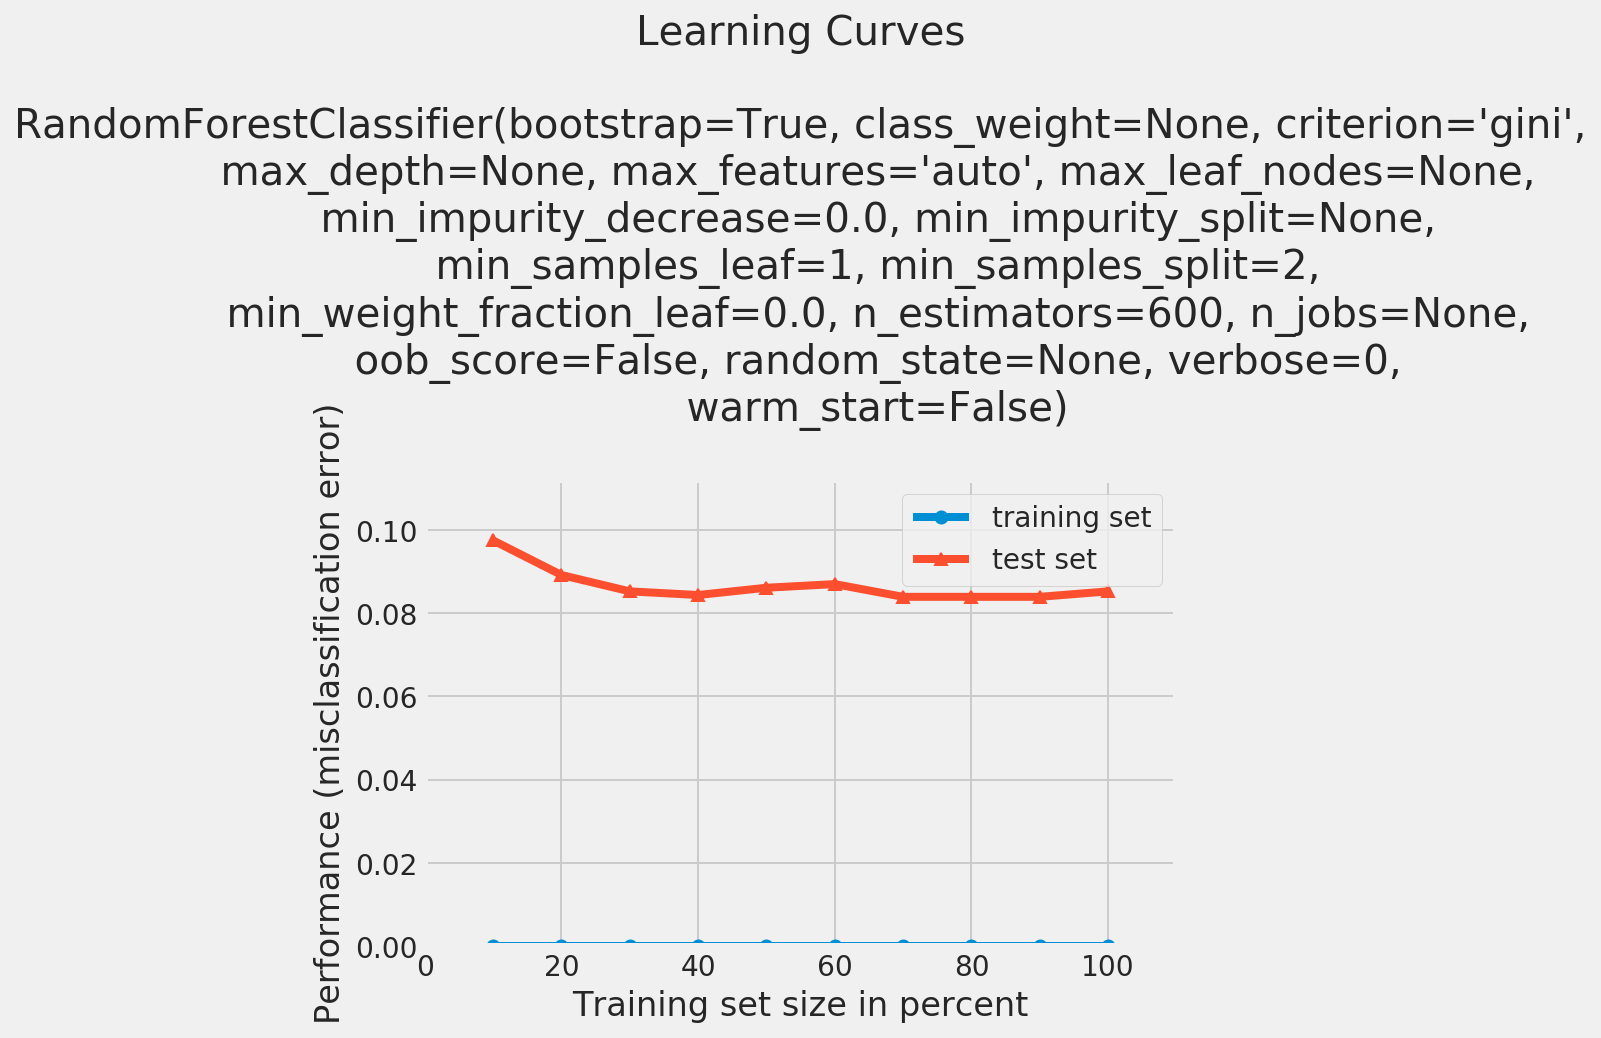

In [217]:
plot_learning_curves(X_train,y_train, X_test, y_test, rfc)
plt.show()

Aqui vemos que o erro no conjunto de treinamento começa e permanece extremamente baixo, enquanto o erro no conjunto de teste é grande. Parece que o erro do conjunto de teste está diminuindo lentamente com mais dados. Isso é característico do overfitting, o modelo está capturando exatamente o comportamento dos dados de treinamento, mas, portanto, não está conseguindo generalizar para novos pontos.

#### Predicão do dataset de validação

In [218]:
# Predicão do dataset de validação
test_pred = rfc.predict(df_valid)
# Dataset para apresentação
previsao = teste.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = test_pred
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==1, 'eleito','nao_eleito')
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    4049
eleito         543
Name: Predicted, dtype: int64

### MODELO 07 - SVM

In [219]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

#### Normalizando os dados com QuantileTransformer

Esse método transforma os recursos para seguir uma distribuição uniforme ou normal. Portanto, para um determinado recurso, essa transformação tende a distribuir os valores mais frequentes. Também reduz o impacto de outliers (marginais): este é, portanto, um esquema robusto de pré-processamento.

In [220]:
from sklearn.preprocessing import QuantileTransformer
# Dimensionando
scaler = QuantileTransformer()
Xqt = X
Xqt = scaler.fit_transform(Xqt)

#### Dividindo os dados em um conjunto de treinamento e conjunto de testes.

In [221]:
# Dividindo os dados em um conjunto de treinamento e conjunto de testes.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xqt,y,test_size=0.30)

In [222]:
# Biblioteca para o modelo
from sklearn.svm import SVC

In [223]:
# Criando o modelo
svm = SVC(gamma='scale')
# Fitando o modelo
svm.fit(X_train,y_train)
# Predição
svm_pred = svm.predict(X_test)

Acurácia do modelo: 0.91
Precision: 0.65
F1 do modelo: 0.68
Recall do modelo: 0.71
AUC ROC: 0.83

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1984
           1       0.65      0.71      0.68       303

   micro avg       0.91      0.91      0.91      2287
   macro avg       0.80      0.83      0.81      2287
weighted avg       0.92      0.91      0.91      2287


Matriz de confusão
[[1868  116]
 [  87  216]]


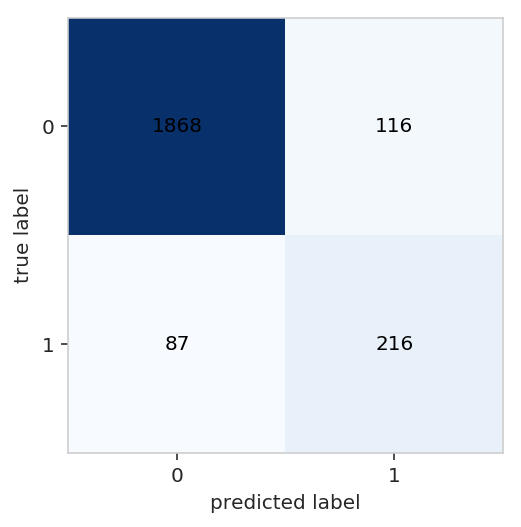

In [224]:
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,svm_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,svm_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,svm_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,svm_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,svm_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,svm_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,svm_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm)

plt.show()

#### Desempenho treino/teste

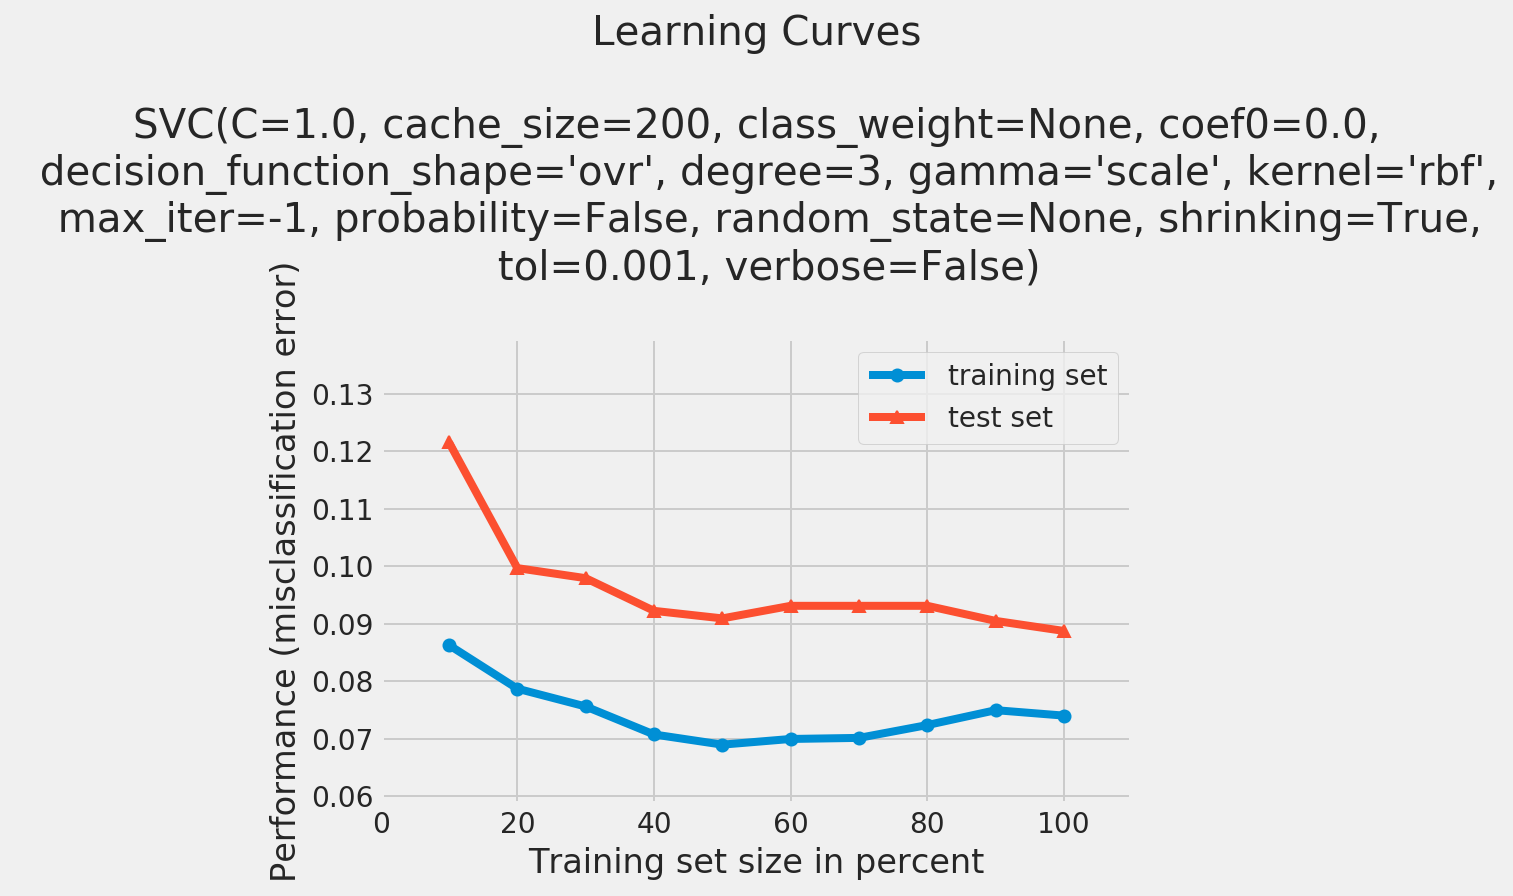

In [231]:
plot_learning_curves(X_train,y_train, X_test, y_test, svm)
plt.show()

O modelo apresenta um comportamento parecido para os dados de treinamento e teste. Seria necessário mais dados de treinamento.

#### Encontrando parâmetro para otimizar o modelo com Gridsearch

O GridSearchCV usa um dicionário que descreve os parâmetros que devem ser testados e um modelo para treinar. A grade de parâmetros é definida como um dicionário, onde as chaves são os parâmetros e os valores são as configurações a serem testadas.

In [100]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 500], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [101]:
from sklearn.model_selection import GridSearchCV

In [102]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)
grid.fit(X_train,y_train)

/media/francinaldo/ARQUIVOS/my_python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV]  C=0.01, gamma=1, kernel=rbf, score=0.866779089376054, total=   1.7s
[CV] C=0.01, gamma=1, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  C=0.01, gamma=1, kernel=rbf, score=0.866779089376054, total=   1.6s
[CV] C=0.01, gamma=1, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV]  C=0.01, gamma=1, kernel=rbf, score=0.867191896454699, total=   1.9s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.866779089376054, total=   0.7s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.866779089376054, total=   0.7s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.867191896454699, total=   0.7s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV]  C=0.01, gamma=0.01, kernel=rbf, score=0.866779089376054, total=   0.8s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV]  C=0.01, gamma=0.01, kernel=rbf, score=0.866779089376054, total=   0.8s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV]  C=0.01, gamma=0.01, kernel=rbf, score=0.867191896454699, total=   0.7s
[CV] C=0.01, gamma=0.001, kernel=rbf ....

[CV]  C=10, gamma=0.0001, kernel=rbf, score=0.866779089376054, total=   1.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV]  C=10, gamma=0.0001, kernel=rbf, score=0.867191896454699, total=   0.9s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV]  C=100, gamma=1, kernel=rbf, score=0.8864530635188308, total=   3.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV]  C=100, gamma=1, kernel=rbf, score=0.893760539629005, total=   3.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV]  C=100, gamma=1, kernel=rbf, score=0.8908272369161508, total=   3.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV]  C=100, gamma=0.1, kernel=rbf, score=0.8836424957841484, total=   0.9s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV]  C=100, gamma=0.1, kernel=rbf, score=0.9050028105677347, total=   0.9s
[CV] C=100, gamma=0.1, kernel=rbf .............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 500], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [225]:
grid.best_params_

{'C': 500, 'gamma': 0.001, 'kernel': 'rbf'}

In [226]:
grid.best_estimator_

SVC(C=500, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Re-executando as previsões neste objeto da grade

In [227]:
grid_pred = grid.predict(X_test)

Acurácia do modelo: 0.92
Precision: 0.69
F1 do modelo: 0.71
Recall do modelo: 0.73
AUC ROC: 0.84

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1984
           1       0.69      0.73      0.71       303

   micro avg       0.92      0.92      0.92      2287
   macro avg       0.82      0.84      0.83      2287
weighted avg       0.92      0.92      0.92      2287


Matriz de confusão
[[1883  101]
 [  81  222]]


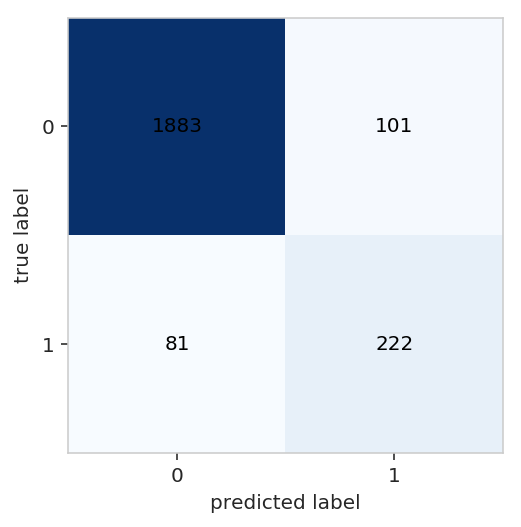

In [228]:
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,grid_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,grid_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,grid_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,grid_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,grid_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,grid_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,grid_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm)

plt.show()

In [232]:
# Normalizando os dados de teste
# Dimensionando
XrbT = df_valid
XrbT = scaler.fit_transform(XrbT)

In [233]:
# Predicão do dataset de validação
test_pred = grid.predict(XrbT)
# Dataset para apresentação
previsao = teste.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = test_pred
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==1, 'eleito','nao_eleito')
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    3997
eleito         595
Name: Predicted, dtype: int64

### MODELO 08 - GradientBoosting

In [234]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

In [235]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [236]:
from sklearn.ensemble import GradientBoostingClassifier

In [237]:
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=9, min_samples_split=6, 
                                min_samples_leaf=20, subsample=.7,max_features=17, random_state=seed)

In [238]:
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=9,
              max_features=17, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=101,
              subsample=0.7, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [239]:
gb_pred = gb.predict(X_test)

Acurácia do modelo: 0.92
Precision: 0.73
F1 do modelo: 0.71
Recall do modelo: 0.69
AUC ROC: 0.82

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1984
           1       0.73      0.69      0.71       303

   micro avg       0.92      0.92      0.92      2287
   macro avg       0.84      0.82      0.83      2287
weighted avg       0.92      0.92      0.92      2287


Matriz de confusão
[[1906   78]
 [  95  208]]


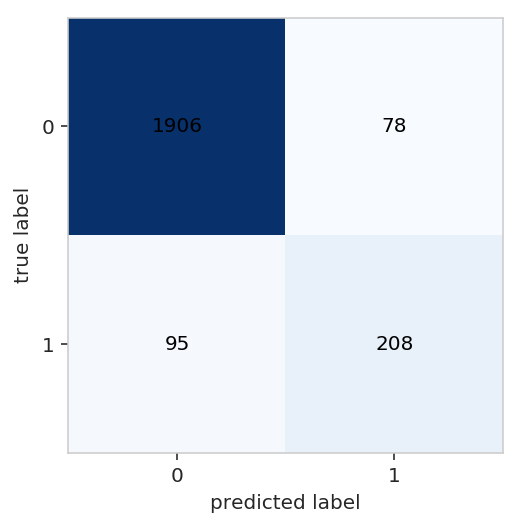

In [240]:
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,gb_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,gb_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,gb_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,gb_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,gb_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,gb_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,gb_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm)

plt.show()

#### Desempenho treino/teste

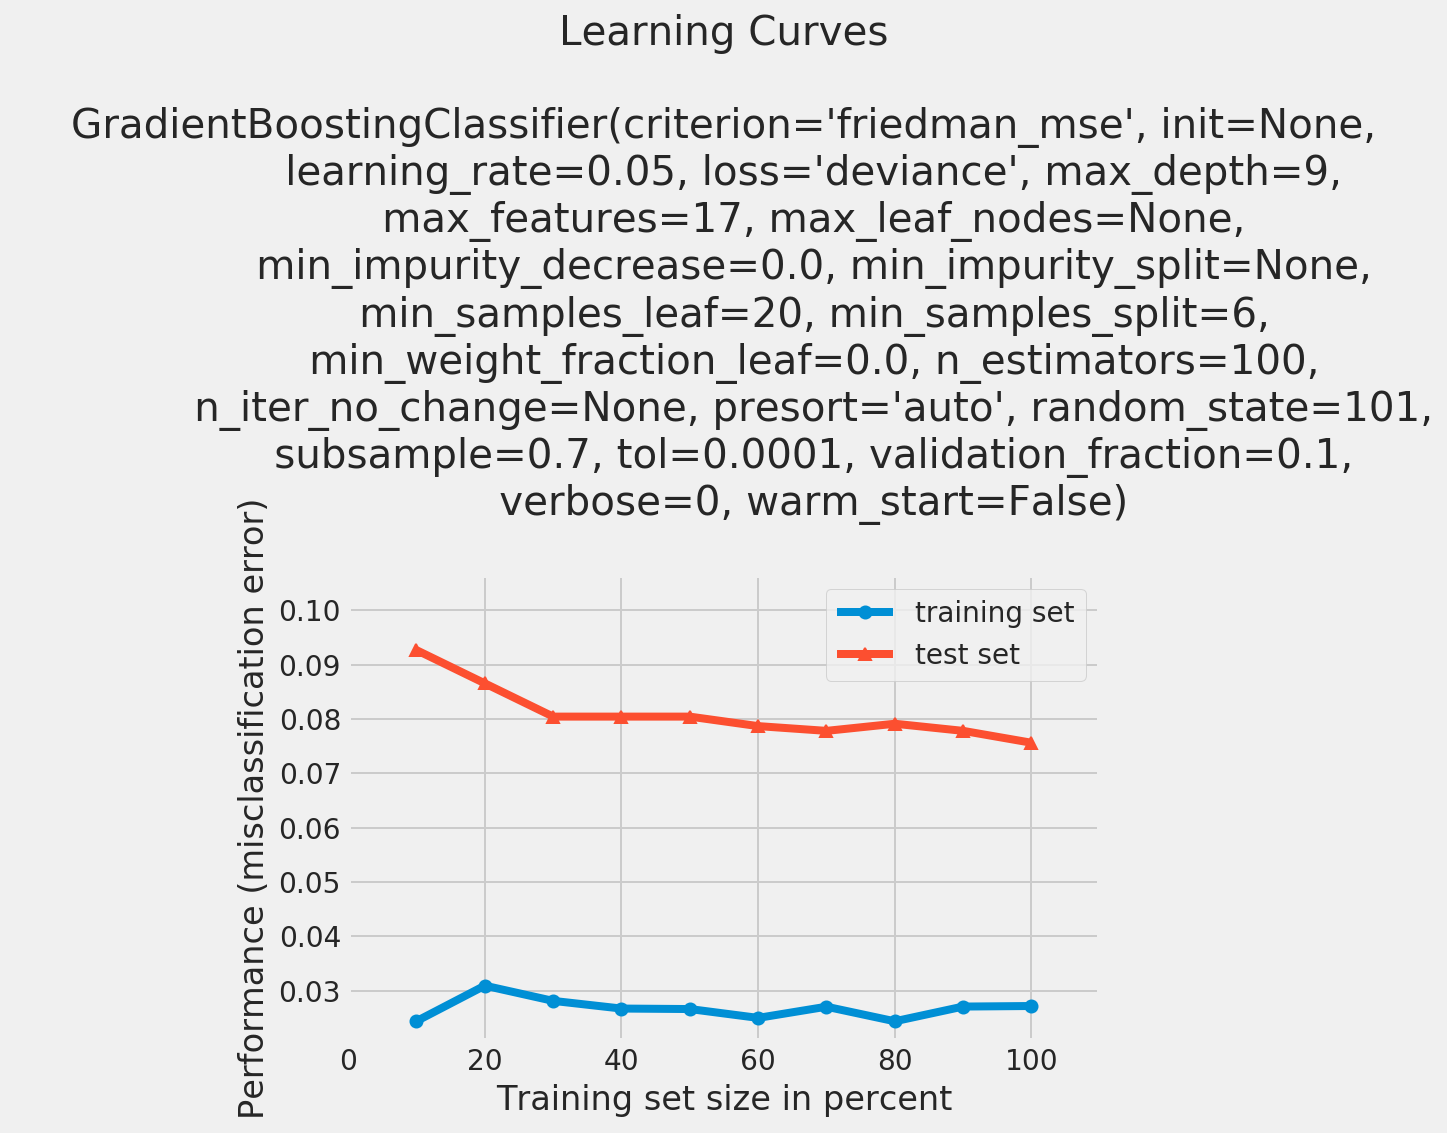

In [241]:
plot_learning_curves(X_train,y_train, X_test, y_test, gb)
plt.show()

Uma curva de aprendizado mostra como o erro muda conforme o tamanho do conjunto de treinamento aumenta. 
Percebemos que a curva de erro vai diminuíndo conforme o tamanho do conjunto de treinamento aumenta.
As curvas não convergiram pois, provavelmente, precisa-se de mais instâncias de treino.
Vemos que que temos um *baixo vies*, pois temos baixo erro no treinamento e uma alta variância devido ao intervalo longo entre as duas curvas.

#### Importância dos atributos

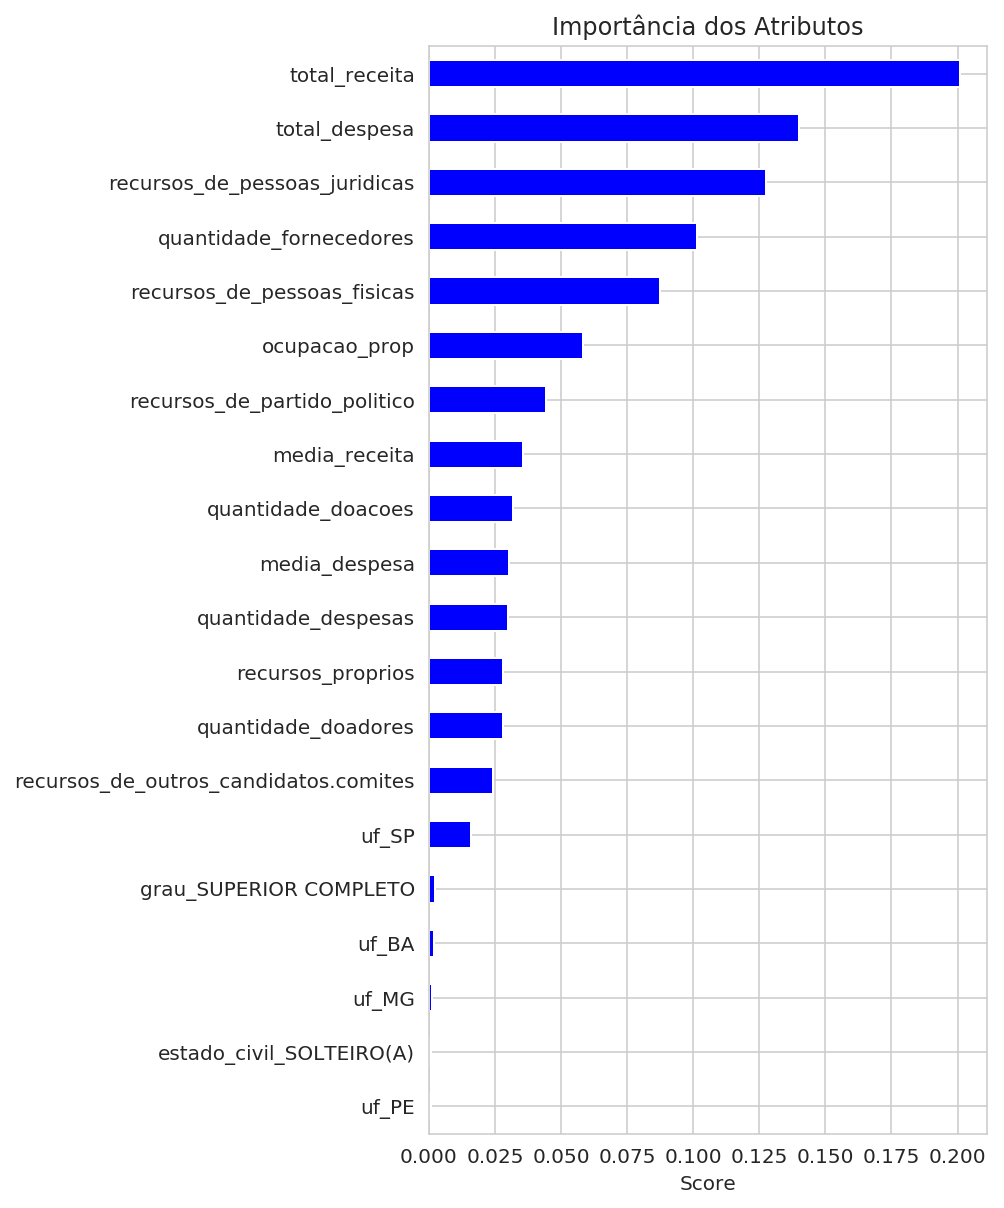

In [242]:
preditores=list(X_train)
feat_imp = pd.Series(gb.feature_importances_, preditores).sort_values(ascending=False)
# plot
plt.subplots(figsize=(5, 10))                       
feat_imp.head(20).plot(kind='barh', title='Importância dos Atributos', color='blue')
plt.xlabel('Score')
plt.gca().invert_yaxis()

In [243]:
# Predicão do dataset de validação
test_pred = gb.predict(df_valid)
# Dataset para apresentação
previsao = teste.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = test_pred
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==1, 'eleito','nao_eleito')
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    4048
eleito         544
Name: Predicted, dtype: int64

### MODELO 09 - Ensemble  BaggingClassifier

In [244]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

In [245]:
### Separando a variáveis preditodas e alvo 
# variáveis preditoras
X = df.drop('situacao',axis=1)
# variável alvo
y = df['situacao']

In [246]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

In [247]:
kfold = model_selection.KFold(n_splits=10, random_state=seed)

gb = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,max_depth=2, min_samples_split=20, 
                                      min_samples_leaf=7, subsample=0.9,max_features=7, random_state=10)

num_trees = 100

ens = BaggingClassifier(base_estimator=gb, n_estimators=num_trees, random_state=seed)

In [248]:
# Fitando o modelo
ens.fit(X_train, y_train)

BaggingClassifier(base_estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_sa...      subsample=0.9, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=101, verbose=0, warm_start=False)

In [252]:
# Predições
ens_pred = ens.predict(X_test)

Acurácia do modelo: 0.92
Precision: 0.72
F1 do modelo: 0.67
Recall do modelo: 0.63
AUC ROC: 0.8

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1984
           1       0.72      0.63      0.67       303

   micro avg       0.92      0.92      0.92      2287
   macro avg       0.83      0.80      0.81      2287
weighted avg       0.92      0.92      0.92      2287


Matriz de confusão
[[1910   74]
 [ 111  192]]


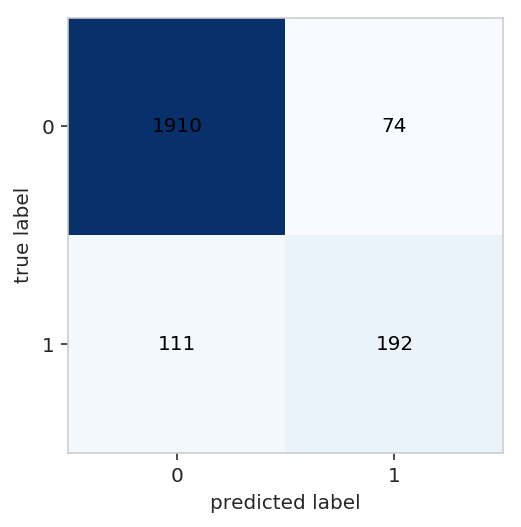

In [253]:
# Acurácia
print(color.BOLD + 'Acurácia do modelo: '  + color.END + str(round(accuracy_score(y_test,ens_pred),2)))
print(color.BOLD + 'Precision: ' + color.END + str(round(precision_score(y_test,ens_pred),2)))
print(color.BOLD + 'F1 do modelo: ' + color.END + str(round(f1_score(y_test,ens_pred),2)))
print(color.BOLD + 'Recall do modelo: ' + color.END + str(round(recall_score(y_test,ens_pred),2)))
print(color.BOLD + 'AUC ROC: ' + color.END + str(round(roc_auc_score(y_test,ens_pred),2)))

# Print do relatório de classificação
cr = classification_report(y_test,ens_pred)
print(color.BOLD + '\nRelatório de Classificação' + color.END)
print(str(cr))

# adicionando resultado na matriz de confusão
cm = confusion_matrix(y_test,ens_pred)
print(color.BOLD + '\nMatriz de confusão' + color.END)
print(str(cm))
plot_confusion_matrix(cm)

plt.show()

#### Desempenho treino/teste

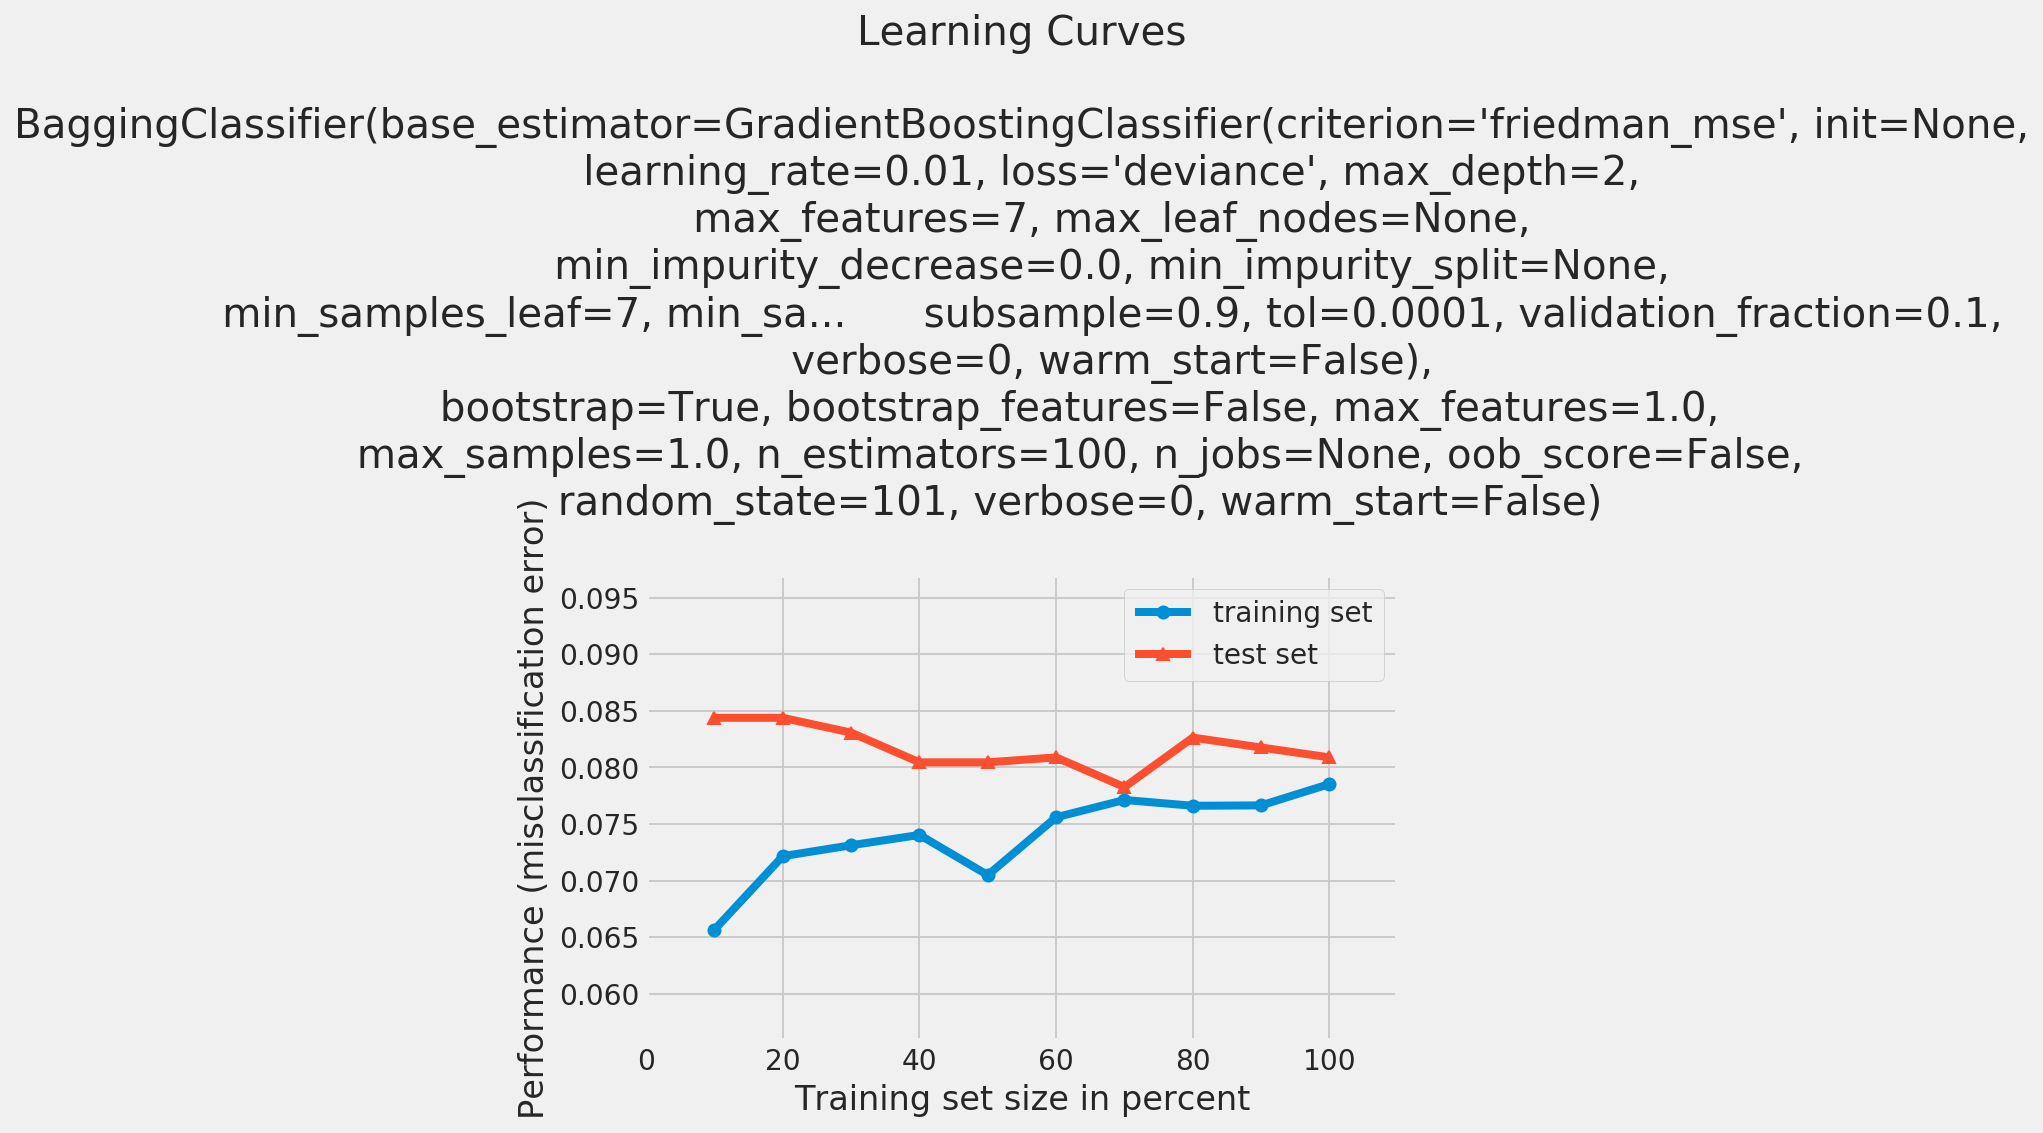

In [254]:
plot_learning_curves(X_train,y_train, X_test, y_test, ens)
plt.show()

O  modelo parece ter generalizado bem, mas com o aumento do tamanho do conjunto de treinamento vemos que o erro, mesmo sendo baixo, vai crescendo.

#### Predicão do dataset de validação

In [255]:
# Predicão do dataset de validação
test_pred = ens.predict(df_valid)
# Dataset para apresentação
previsao = teste.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = test_pred
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==1, 'eleito','nao_eleito')
# Salvando dataset
previsao.to_csv('predicoes/predicted_ens_tunning.csv', index=False)
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    4078
eleito         514
Name: Predicted, dtype: int64

#### OBSERVAÇÕES

Os parâmetros utilizados no GradientBoostingClassifier foram obtidos entre as melhores combinações feitas através do GridSearch que foi interrompido devido ao tempo que levaria para finalizar.
Entres as combinações a com melhor score foi:

[CV]  learning_rate=0.01, max_depth=2, max_features=7, min_samples_leaf=7, min_samples_split=20, n_estimators=500, subsample=0.9, score=0.9251968503937008, total=   0.7s

##### Parâmetros utilizados no GridSearch
    param_grid = {'learning_rate':[0.01,0.05,0.1], 'n_estimators':[50,100,250,500],
              'max_depth':[2,3,4,5,7,9], 'min_samples_split':[2,4,6,8,10,20,40,60,100], 
              'min_samples_leaf':[1,3,5,7,9],'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1],
             'max_features':[2,3,4,5,6,7]} 
             
             
###### GridSearch

    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True,verbose=3)
    grid.fit(X_train,y_train)